
Sphere: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=71744ed14e799c1abd28c70ab309584f905fe7fa10e21fae27fa8ee0d9a64d8e
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Sphere'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Sphere(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * ( x1_training ** 2
                            + x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1653156093.910392

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 1.5925778782479172	 1.5925778782479172
2  	 [5.12 5.12]	 52.4288	 1.275455677703416	 1.592577857354429	 1.5925778776207775
3  	 [-5.12  5.12]	 52.4288	 1.275455677703416	 1.5922073219901	 1.5925740218285798
4  	 [3.42251956 0.51119949]	 11.97496503816794	 1.275455677703416	 1.5922728205184895	 1.5922785146401637
5  	 [ 0.43770207 -2.49215347]	 6.4024119920449305	 1.275455677703416	 1.5822509448521345	 1.5826945606

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 1.1945156055900972	 1.1945155933603315
2  	 [ 4.81450792 -3.13469502]	 33.005799380417244	 0.6972563370202991	 1.1945141515817608	 1.194514350242494
3  	 [-0.00665776  5.12      ]	 26.21444432583058	 0.6972563370202991	 1.1944864421276367	 1.1944864862721718
4  	 [-5.12  5.12]	 52.4288	 0.6972563370202991	 1.1935282185315044	 1.1943096649610914
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 1.1935282184940879

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 4.62467038 -1.72561535]	 24.365324472273187	 4.59675431006429	 4.604079794844259	 4.604111310212334
2  	 [-4.56742798  5.09256728]	 46.79563988817364	 4.59675431006429	 4.604086787944704	 4.604110921080363
3  	 [ 0.8288545 -5.12     ]	 26.90139978255084	 4.59675431006429	 4.604030963312919	 4.60406114228067
4  	 [-0.43215432  5.12      ]	 26.40115735336559	 4.59675431006429	 4.5806085855735414	 4.5818448244688375
5	 [ 0.82737174 -1.28008905]	 2.323171963570444	 2.323171963570444	 4.57010

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-5.12       4.1377311]	 43.335218618634045	 6.844040613967918	 6.844198691403709	 6.844198513007146
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 6.844193745736039	 6.844193745736039
3  	 [0.30932389 5.12      ]	 26.31008127124508	 6.844040613967918	 6.844187788743423	 6.8441879845529305
4  	 [-0.95718126 -5.12      ]	 27.130595972317224	 6.844040613967918	 6.832540437341447	 6.8332875571880445
5	 [0.7023172  1.02864621]	 1.551362481866165	 1.551362481866165	 6.829070473279749	 6.83

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 1.6281597426122008	 1.6281597426122008
2  	 [5.12       5.01289921]	 51.34355847678091	 1.3234068721819314	 1.6281595760134915	 1.6281590119024378
3  	 [-5.12       -0.04786204]	 26.216690774551555	 1.3234068721819314	 1.6272897908789585	 1.6274860861076026
4  	 [0.96522328 5.12      ]	 27.146055978993424	 1.3234068721819314	 1.6210282814921657	 1.6210808980444364
5  	 [-5.12 -5.12]	 52.4288	 1.32340687218193

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [4.11612367 5.12      ]	 43.15687410118326	 0.7844720799352826	 1.250722557209966	 1.2507225569796536
2  	 [-5.12 -5.12]	 52.4288	 0.7844720799352826	 1.2507225040704095	 1.250722531315433
3  	 [-5.12  5.12]	 52.4288	 0.7844720799352826	 1.2501443885870325	 1.2501641658874603
4  	 [-0.45134291  5.12      ]	 26.41811042514197	 0.7844720799352826	 1.249653242645534	 1.249653242646556
5  	 [-0.92587149 -4.00794366]	 16.920850403701305	 0.7844720799352826	 1.24733901458374	 1.2

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 5.623970530540822	 5.623970530540822
2  	 [ 5.12 -5.12]	 52.4288	 5.622519010932044	 5.623914820132658	 5.623965991173253
3  	 [3.33467007 5.12      ]	 37.334424459527995	 5.622519010932044	 5.623914825282074	 5.623914822239006
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 5.6239846283798745	 5.6239846283798745
5	 [ 1.22341757 -0.77267985]	 2.0937847088009414	 2.0937847088009414	 5.602642206875012	 5.602669

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [-4.35314394e-04  2.06672084e+00]	 4.2713352253780394	 0.10287109474532606	 0.8513248707571486	 0.8513709009550652
2  	 [-5.12  5.12]	 52.4288	 0.10287109474532606	 0.850372956370729	 0.8503753017825905
3  	 [ 4.04654016 -5.12      ]	 42.58888725134649	 0.10287109474532606	 0.8500636183393022	 0.8503739366108233
4  	 [-5.12       -0.23610204]	 26.270144171138686	 0.10287109474532606	 0.8503427319936969	 0.8503427325829758
5  	 [-0.87216393  5.12      ]	 26.97506991215287

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.69491889 4.82146316]	 36.89893267190826	 7.349882113053805	 7.349939623433926	 7.349939623433926
2  	 [-2.28372885  5.12      ]	 31.42981746611072	 7.349882113053805	 7.349938469633026	 7.349938683254624
3  	 [ 5.12       -0.74247413]	 26.7656678346878	 7.349882113053805	 7.349938665258708	 7.349938231664594
4  	 [ 4.43938421 -5.12      ]	 45.92253220543576	 7.349882113053805	 7.348906613748904	 7.349095535908969
5	 [0.56836094 1.32766495]	 2.0857283711970505	 2.0857283711970

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.36519049]	 26.347764096654153	 7.941821858928501	 7.941750846391455	 7.94175100591391
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 7.941699776822621	 7.941699776822621
3  	 [-5.12      -0.5961872]	 26.569839180648568	 7.941821858928501	 7.9042115618590545	 7.931984859739931
4  	 [-0.58314824  5.12      ]	 26.55446186947041	 7.941821858928501	 7.84874446956999	 7.901342604997661
5  	 [-5.12  5.12]	 52.4288	 7.941821858928501	 7.792870589463077	 7.888766805415776
6	 [-

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 1.1898686681311723	 1.1898686681311723
2  	 [-5.12  5.12]	 52.4288	 0.6899456214148796	 1.1875807721510645	 1.189860132757955
3  	 [ 5.12       -0.71940583]	 26.731944749259178	 0.6899456214148796	 1.1881130892164176	 1.1881163372712598
4  	 [0.92473106 5.12      ]	 27.0695275304425	 0.6899456214148796	 1.170848367853455	 1.1708717772084891
5  	 [-0.19961096 -2.46512015]	 6.116661912497046	 0.6899456214148796	 1

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 5.994237365089219	 5.994237365089377
2  	 [-4.3128375 -5.12     ]	 44.81496732408011	 5.993464196233534	 5.994237270309308	 5.994237214572344
3	 [2.28114697 0.7790445 ]	 5.810541841052088	 5.810541841052088	 5.994126043789471	 5.994127756949446
4  	 [0.22737527 5.12      ]	 26.26609951548339	 5.810541841052088	 5.811187981392776	 5.811187981404254
5  	 [-0.12464734 -3.128188  ]	 9.801097136323943	 5.810541841052088	 5.808869023702846	 5.8099

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 7.271568186278327	 7.271568186175726
2  	 [-5.12        2.98564537]	 35.128478246375195	 7.271500601275535	 7.271535544350283	 7.27156701700843
3  	 [-0.59461941 -5.12      ]	 26.56797224717891	 7.271500601275535	 7.269457950786211	 7.269457950856825
4  	 [-1.6689609  5.12     ]	 28.999830474949565	 7.271500601275535	 7.259312830511488	 7.261197888195587
5	 [-0.68838239 -0.62671217]	 0.8666384578574938	 0.8666384578574938

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.12 -5.12]	 52.4288	 3.480496204392171	 3.5136325940103443	 3.513633268751706
2  	 [5.10053766 5.12      ]	 52.22988440813188	 3.480496204392171	 3.513632316382479	 3.5136322122808483
3  	 [-5.12       0.3937393]	 26.36943063604084	 3.480496204392171	 3.5136187572219786	 3.513618757181347
4  	 [ 5.12       -0.07492317]	 26.220013481176004	 3.480496204392171	 3.5135609579766314	 3.5135614377551314
5	 [-1.58751451  0.05051814]	 2.52275440718527	 2.52275440718527	 3.435274639191439

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [2.7754098  2.98802689]	 16.631204280641075	 5.383887924980681	 5.386064667626315	 5.38606446985145
2  	 [-5.12       4.8956798]	 50.18208072265904	 5.383887924980681	 5.386036541246718	 5.3860634052597955
3  	 [-0.71829908  5.12      ]	 26.730353569056998	 5.383887924980681	 5.382634194234779	 5.382635944169028
4  	 [-0.11962856 -5.12      ]	 26.228710992847983	 5.383887924980681	 5.365944722733987	 5.379105272367038
5  	 [5.12       0.18688251]	 26.24932507195853	 5.38388792498

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [2.2392668 5.12     ]	 31.228715816373875	 8.084978900492077	 8.084990718072902	 8.084990713563913
2  	 [5.12       0.62072784]	 26.5997030553861	 8.084978900492077	 8.084969734789714	 8.084969734465192
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 8.084598853373462	 8.084598853373462
4	 [0.93966398 0.94349823]	 1.773157306760156	 1.773157306760156	 8.07850167477004	 8.078810139237648
5  	 [ 5.12 -5.12]	 52.4288	 1.773157306760156	 1.932273625579759	 1.97030221890042
6  	 [-0.9

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 2.6751832097646906	 2.6751832097646906
2  	 [-4.96101555  4.71820579]	 46.87314117535796	 2.5824114132885994	 2.6751668747334127	 2.675181105346386
3  	 [4.81190763e-03 5.12000000e+00]	 26.21442315445503	 2.5824114132885994	 2.6749391403545237	 2.674939139306995
4  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 2.674214720428268	 2.674214720428268
5  	 [ 0.85280877 -2.81527825]	 8.653074444448364	 2.5824114132885994

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 2.489407676741919	 2.489407676741919
2  	 [-5.12       -1.45227085]	 28.323490628391887	 2.3742017032787373	 2.4867349492798945	 2.48699639877795
3  	 [-1.15624254  1.83901653]	 4.718878608730969	 2.3742017032787373	 2.4768113082781307	 2.477396506884893
4  	 [-2.03882838  5.12      ]	 30.37122118050353	 2.3742017032787373	 2.454072562637202	 2.455852654222366
5  	 [-0.98970093 -1.46069554]	 3.113139388866342	 2.

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.75278676 -5.12      ]	 48.803381992636034	 12.957869519084127	 12.957842947554632	 12.95786949647841
2	 [ 1.50901475 -1.41193475]	 4.270685262457224	 4.270685262457224	 12.954870337589359	 12.955950074065907
3  	 [5.12 5.12]	 52.4288	 4.270685262457224	 4.267120511634693	 4.267120511634693
4  	 [-5.12       -1.05768786]	 27.33310360807076	 4.270685262457224	 4.264892259075372	 4.2660745287524255
5  	 [-1.25757946  5.12      ]	 27.795906086660352	 4.270685262457224	 4.24964

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.5657182 -5.12     ]	 38.92874624990874	 1.579257056101869	 1.8240963904605108	 1.8240962412946324
2  	 [ 5.12 -5.12]	 52.4288	 1.579257056101869	 1.8223127630850753	 1.8226209041374526
3  	 [ 5.12       -0.75178117]	 26.779574928021688	 1.579257056101869	 1.8180438918581252	 1.8200109105994313
4  	 [-2.73894121  5.12      ]	 33.71619895459257	 1.579257056101869	 1.809548379399159	 1.809548777113998
5  	 [-5.12       -1.69408661]	 29.08432945535154	 1.579257056101869	 1.76170433263

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1653157562.3532155

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 1.5925778782479172	 1.5925778782479172
2  	 [5.12       3.36783542]	 37.55671539878192	 1.275455677703416	 1.592577857354429	 1.5925778776207775
3  	 [ 2.40146578 -0.17378187]	 5.797238022053689	 1.275455677703416	 1.5899887414526428	 1.592574021828699
4  	 [-5.12        4.36680096]	 45.28335059684448	 1.275455677703416	 1.592552727046903	 1.592574021989678
5  	 [1.30762101 5.12      ]	 27.924272700727766	 1.27545

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [5.12 5.12]	 52.4288	 0.6972563370202991	 1.1945156055900972	 1.1945155933603315
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 1.1945141517615334	 1.1945142517643457
3  	 [-0.14724304  5.12      ]	 26.236080513371153	 0.6972563370202991	 1.194472843498889	 1.19447286679032
4  	 [4.19814932 0.55652488]	 17.934177627777412	 0.6972563370202991	 1.1937448998515563	 1.194291556464915
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 1.1935282244680223	 1.

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 2.87036899 -1.98289163]	 12.170877343622498	 4.59675431006429	 4.604079794844259	 4.604111310212334
2  	 [-3.33114862  5.05305125]	 36.62987805318713	 4.59675431006429	 4.6040867880204726	 4.6041109368494615
3  	 [-0.40701955 -2.40839967]	 5.966053860772153	 4.59675431006429	 4.53181634231452	 4.602649661707822
4  	 [ 1.47776527 -5.12      ]	 28.398190192382167	 4.59675431006429	 4.574993886896152	 4.60061981063856
5  	 [5.12       0.52669006]	 26.491802422845403	 4.59675431006429	 4.566

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-1.14334581  4.64643194]	 22.896569443900606	 6.844040613967918	 6.844198691403709	 6.844198513007146
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 6.844193745732506	 6.844193745732506
3  	 [-0.95819369 -5.12      ]	 27.132535153656406	 6.844040613967918	 6.833287493862271	 6.843156486746256
4	 [0.65712638 1.17928828]	 1.8225359163068036	 1.8225359163068036	 6.831378150964439	 6.843156497605809
5  	 [-5.12        2.45166061]	 32.22503973412286	 1.8225359163068036	 2.0182197598880456

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 1.6281597426122008	 1.6281597426122008
2  	 [5.12 5.12]	 52.4288	 1.3234068721819314	 1.6281595760134915	 1.6281590119024378
3  	 [-5.12       -0.27719042]	 26.29123452807068	 1.3234068721819314	 1.6272897908789583	 1.6274860861082332
4  	 [0.99551455 5.11914473]	 27.1966919681028	 1.3234068721819314	 1.620924980517749	 1.6209899439312656
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 1.6196491999775522	 1.

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [5.12 5.12]	 52.4288	 0.7844720799352826	 1.250722557209966	 1.2507225569796536
2  	 [-3.74535283 -5.12      ]	 40.24206779776266	 0.7844720799352826	 1.2507225040704095	 1.250722531315433
3  	 [0.08402923 5.12      ]	 26.221460911676587	 0.7844720799352826	 1.2505187585884068	 1.2505187583331112
4  	 [2.56669879 1.74876145]	 9.646109280504115	 0.7844720799352826	 1.241133012953653	 1.250152909436129
5  	 [-0.25046164 -3.54643381]	 12.639923790732329	 0.7844720799352826	 1.

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 5.623970530540822	 5.623970530540822
2  	 [3.33590081 5.12      ]	 37.342634208733344	 5.622519010932044	 5.623914820132658	 5.623965991173253
3  	 [ 4.5235682  -4.16736717]	 37.82961837123037	 5.622519010932044	 5.623289213108925	 5.623965991182763
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 5.6239846283798745	 5.6239846283798745
5	 [ 1.20807972 -0.75572559]	 2.0305777820257194	 2.0305777820257194	 5.602

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [0.02041459 1.98577863]	 3.943733542072024	 0.10287109474532606	 0.8513248707571486	 0.8513709009550652
2  	 [-5.03492225  2.95509263]	 34.08301446412634	 0.10287109474532606	 0.8503734940757717	 0.8503753093621098
3  	 [-5.12       -1.47896116]	 28.40172612269111	 0.10287109474532606	 0.8488848361561557	 0.8503744367855921
4  	 [ 2.57855628 -4.69210849]	 28.66483461803054	 0.10287109474532606	 0.8503612250776876	 0.8503747380403475
5  	 [0.12155999 4.9809562 ]	 24.82470

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [4.68664599 5.12      ]	 48.179050673140004	 7.349882113053805	 7.349939623433926	 7.349939623433926
2  	 [ 4.93512605 -1.14868802]	 25.674953297624498	 7.349882113053805	 7.349938575846465	 7.349938542547139
3  	 [-1.47922339  4.44879978]	 21.979921333163915	 7.349882113053805	 7.349938263911135	 7.34993891079297
4	 [1.09349406 1.13408365]	 2.4818749979390615	 2.4818749979390615	 7.347285794193946	 7.34748583794475
5  	 [3.50678683 1.84048058]	 15.68492261118841	 2.481874997939

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.34675903]	 26.33464182441566	 7.941821858928501	 7.941750846391455	 7.94175100591391
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 7.941699369416504	 7.941699369416504
3  	 [-4.21705607 -0.7275049 ]	 18.31282532366967	 7.941821858928501	 7.904211561858475	 7.931984859739974
4  	 [0.65867346 5.11113959]	 26.5575986246983	 7.941821858928501	 7.818599464701568	 7.901350043956328
5	 [ 0.09877078 -0.03903922]	 0.011279726611796229	 0.011279726611796229	 7.794630075339411	 

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 1.1898686681311723	 1.1898686681311723
2  	 [ 4.94072018 -0.61728397]	 24.791755402212313	 0.6899456214148796	 1.1875807721510645	 1.189860132757955
3  	 [-1.19896852  5.12      ]	 27.651925507645664	 0.6899456214148796	 1.1666838274617444	 1.1898601327579634
4  	 [ 1.19392454 -1.30462948]	 3.1275138631117585	 0.6899456214148796	 1.1596509704568805	 1.1865771303381993
5  	 [-3.74685469  2.91006244]	 22.507383479

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12       4.28576605]	 44.58219063385849	 5.993464196233534	 5.994237365089219	 5.994237365089377
2  	 [-5.12       -4.85983818]	 49.83242712805688	 5.993464196233534	 5.994237270309308	 5.994237181038485
3  	 [0.29710703 5.12      ]	 26.30267258716383	 5.993464196233534	 5.993927587379909	 5.993927587892253
4	 [1.89092034 0.56120834]	 3.8905345163315044	 3.8905345163315044	 5.993730915116168	 5.9938778172645035
5  	 [-0.44602232 -4.06809875]	 16.748363342391862	 3.89053451633150

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.18648609 -2.4678052 ]	 23.616728302103265	 7.271500601275535	 7.271568186278327	 7.271568186175726
2  	 [-3.79946932  2.66821301]	 21.55532775288146	 7.271500601275535	 7.271525357105591	 7.2715672956188016
3  	 [-0.69739246 -5.12      ]	 26.700756242868632	 7.271500601275535	 7.270026503494135	 7.27002706594453
4	 [-0.58669696 -0.75006876]	 0.9068164551257099	 0.9068164551257099	 7.258896672486266	 7.2591333250965775
5  	 [-0.94715615  5.12      ]	 27.111504777750348	 0.90681645512

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.12       -0.19377072]	 26.25194709281843	 3.480496204392171	 3.5136325940103443	 3.513633268751706
2  	 [5.12 5.12]	 52.4288	 3.480496204392171	 3.5136323163824983	 3.513632221502314
3  	 [-4.34551125 -5.12      ]	 45.09786803255743	 3.480496204392171	 3.5135793432928555	 3.5135814529240594
4  	 [ 5.12       -0.05216576]	 26.21712126687544	 3.480496204392171	 3.5135608281387327	 3.513561299756159
5	 [-1.73473933  0.36160505]	 3.140078760998255	 3.140078760998255	 3.435235881328

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [5.12       4.67669476]	 48.08587386986069	 5.383887924980681	 5.386064667626315	 5.38606446985145
2  	 [-0.5836373  5.12     ]	 26.555032493543965	 5.383887924980681	 5.386057491871865	 5.386062879522706
3  	 [-5.12        3.54942235]	 38.81279901094424	 5.383887924980681	 5.385656207278279	 5.3857725666568275
4  	 [2.58493343 0.8618431 ]	 7.42465433620531	 5.383887924980681	 5.384058792111845	 5.385217954239817
5  	 [-0.98214977 -5.12      ]	 27.17901817882703	 5.38388792498068

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [3.27469422 5.12      ]	 36.93802224021954	 8.084978900492077	 8.084990718072902	 8.084990713563913
2  	 [5.12       0.30279176]	 26.30608285158056	 8.084978900492077	 8.084921598492175	 8.084921606881817
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 8.084598853372793	 8.084598853372793
4	 [0.90509598 1.39472461]	 2.7644554690851795	 2.7644554690851795	 8.0809249111166	 8.080936127608664
5  	 [-0.22984736  3.68951112]	 13.665322149736932	 2.7644554690851795	 2.7775076338434554	

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 2.6751832097646906	 2.6751832097646906
2  	 [-1.21990793  5.12      ]	 27.70257535209655	 2.5824114132885994	 2.6751668747334127	 2.675181105346386
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 2.67423926333734	 2.67423926333734
4  	 [ 0.90891898 -3.03876689]	 10.060237903108394	 2.5824114132885994	 2.6713887357979926	 2.6736737264498016
5  	 [-4.82762476  2.72283122]	 30.719770625377336	 2.5824114132885994	 2.6

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 2.489407676741919	 2.489407676741919
2  	 [-2.20660477 -0.45183714]	 5.073261429346723	 2.3742017032787373	 2.4867349492798945	 2.48699639877795
3  	 [-1.33223764  2.98566968]	 10.689080551059877	 2.3742017032787373	 2.451496800344446	 2.4724598113453378
4  	 [-5.12      -1.9319886]	 29.946979952812764	 2.3742017032787373	 2.472466381686154	 2.4724813518934052
5  	 [ 0.17835775 -2.37604674]	 5.677409592475777	 2.

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.82668731 -3.73098301]	 37.21714456946748	 12.957869519084127	 12.957842947554632	 12.95786949647841
2	 [-0.64696019 -0.05249445]	 0.4213131500748724	 0.4213131500748724	 12.952859473608974	 12.95506647551881
3  	 [5.12 5.12]	 52.4288	 0.4213131500748724	 1.0171312288936203	 1.0173059898972407
4  	 [-5.12       -1.17676652]	 27.599179438918725	 0.4213131500748724	 1.0159262785670076	 1.0173065853557277
5  	 [ 1.49625134 -0.9344517 ]	 3.111968058662604	 0.4213131500748724	 1

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.59633469 -5.12      ]	 39.1480231675953	 1.579257056101869	 1.8240963904605108	 1.8240962412946324
2  	 [ 5.12       -1.04833609]	 27.313408558419926	 1.579257056101869	 1.8223127630306013	 1.822620904070245
3  	 [-2.35021732  4.6689615 ]	 27.322722964184308	 1.579257056101869	 1.7806827280969495	 1.819929792373745
4  	 [-3.87977034 -1.48779248]	 17.266144365339457	 1.579257056101869	 1.7811368477317673	 1.819929792372934
5  	 [1.79013693 0.16049596]	 3.2303491925659467	 1.5792570

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


1448.9526987075806

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-2.6918469228771156, -4.193036367682318)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-2.711293002171258, -4.326287391135164)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-4.357198267780101, -3.3716348667067533)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-2.5463855461082034, -3.4798091404251115)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-3.748566775219627, -3.027565175434478)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-3.189502164454321, -2.471962941084676)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-4.3662822084598405, -4.6151548390674915)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-3.160239593635745, -5.961153403862587)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-1.963687491893934, -1.8654220526320782)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-5.93446252771342, -4.484748269748821)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-3.4752852540133805, -7.20956277230277)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-2.470613625739771, -2.423356944231762)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-3.3930425563860522, -5.816855822016586)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-5.93484946749287, -6.607463114879785)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(-4.921366657382307, -7.983957903641856)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(-2.587853379643394, -1.527896843811257)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-2.9188701017717396, -4.031355336767628)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-3.3811667263349734, -3.900654837223617)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-7.483850053449757, -2.9794320496133238)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(-4.00227413613903, -5.129465359422259)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

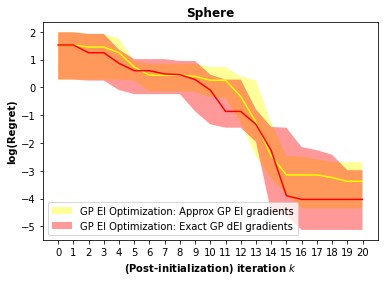

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(1468.442727804184, 1448.9526987075806)

In [100]:
min_ei = 0


In [101]:
### acqFunc regret minimization: run number = 1

### Exact
acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history) 
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

acqFuncApproxRegret_exact_1 = np.log(acqFuncApprox_exact_1 - min_ei)
acqFuncExactRegret_exact_1 = np.log(acqFuncExact_exact_1 - min_ei)

acqFuncApproxSimpleRegret_exact_1 = min_max_array(acqFuncApproxRegret_exact_1)
acqFuncExactSimpleRegret_exact_1 = min_max_array(acqFuncExactRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1 = min(acqFuncApproxSimpleRegret_exact_1)
min_acqFuncExactSimpleRegret_exact_1 = min(acqFuncExactSimpleRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1, min_acqFuncExactSimpleRegret_exact_1


(-0.7657433362821564, -1.302484167214258)

In [102]:
### acqFunc regret minimization: run number = 2

### Exact
acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history) 
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

acqFuncApproxRegret_exact_2 = np.log(acqFuncApprox_exact_2 - min_ei)
acqFuncExactRegret_exact_2 = np.log(acqFuncExact_exact_2 - min_ei)

acqFuncApproxSimpleRegret_exact_2 = min_max_array(acqFuncApproxRegret_exact_2)
acqFuncExactSimpleRegret_exact_2 = min_max_array(acqFuncExactRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2 = min(acqFuncApproxSimpleRegret_exact_2)
min_acqFuncExactSimpleRegret_exact_2 = min(acqFuncExactSimpleRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2, min_acqFuncExactSimpleRegret_exact_2


(-0.6504268086967847, -0.7080093574533922)

In [103]:
### acqFunc regret minimization: run number = 3

### Exact
acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history) 
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

acqFuncApproxRegret_exact_3 = np.log(acqFuncApprox_exact_3 - min_ei)
acqFuncExactRegret_exact_3 = np.log(acqFuncExact_exact_3 - min_ei)

acqFuncApproxSimpleRegret_exact_3 = min_max_array(acqFuncApproxRegret_exact_3)
acqFuncExactSimpleRegret_exact_3 = min_max_array(acqFuncExactRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3 = min(acqFuncApproxSimpleRegret_exact_3)
min_acqFuncExactSimpleRegret_exact_3 = min(acqFuncExactSimpleRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3, min_acqFuncExactSimpleRegret_exact_3


(-0.6474744636100366, -0.9676779075444528)

In [104]:
### acqFunc regret minimization: run number = 4

### Exact
acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history) 
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

acqFuncApproxRegret_exact_4 = np.log(acqFuncApprox_exact_4 - min_ei)
acqFuncExactRegret_exact_4 = np.log(acqFuncExact_exact_4 - min_ei)

acqFuncApproxSimpleRegret_exact_4 = min_max_array(acqFuncApproxRegret_exact_4)
acqFuncExactSimpleRegret_exact_4 = min_max_array(acqFuncExactRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4 = min(acqFuncApproxSimpleRegret_exact_4)
min_acqFuncExactSimpleRegret_exact_4 = min(acqFuncExactSimpleRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4, min_acqFuncExactSimpleRegret_exact_4


(-0.6896146358275986, -0.7991603774034094)

In [105]:
### acqFunc regret minimization: run number = 5

### Exact
acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history) 
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

acqFuncApproxRegret_exact_5 = np.log(acqFuncApprox_exact_5 - min_ei)
acqFuncExactRegret_exact_5 = np.log(acqFuncExact_exact_5 - min_ei)

acqFuncApproxSimpleRegret_exact_5 = min_max_array(acqFuncApproxRegret_exact_5)
acqFuncExactSimpleRegret_exact_5 = min_max_array(acqFuncExactRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5 = min(acqFuncApproxSimpleRegret_exact_5)
min_acqFuncExactSimpleRegret_exact_5 = min(acqFuncExactSimpleRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5, min_acqFuncExactSimpleRegret_exact_5


(-0.6499961286502435, -0.6589937442200744)

In [106]:
### acqFunc regret minimization: run number = 6

### Exact
acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history) 
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

acqFuncApproxRegret_exact_6 = np.log(acqFuncApprox_exact_6 - min_ei)
acqFuncExactRegret_exact_6 = np.log(acqFuncExact_exact_6 - min_ei)

acqFuncApproxSimpleRegret_exact_6 = min_max_array(acqFuncApproxRegret_exact_6)
acqFuncExactSimpleRegret_exact_6 = min_max_array(acqFuncExactRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6 = min(acqFuncApproxSimpleRegret_exact_6)
min_acqFuncExactSimpleRegret_exact_6 = min(acqFuncExactSimpleRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6, min_acqFuncExactSimpleRegret_exact_6


(-0.6176126588796347, -1.1056934364483502)

In [107]:
### acqFunc regret minimization: run number = 7

### Exact
acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history) 
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

acqFuncApproxRegret_exact_7 = np.log(acqFuncApprox_exact_7 - min_ei)
acqFuncExactRegret_exact_7 = np.log(acqFuncExact_exact_7 - min_ei)

acqFuncApproxSimpleRegret_exact_7 = min_max_array(acqFuncApproxRegret_exact_7)
acqFuncExactSimpleRegret_exact_7 = min_max_array(acqFuncExactRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7 = min(acqFuncApproxSimpleRegret_exact_7)
min_acqFuncExactSimpleRegret_exact_7 = min(acqFuncExactSimpleRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7, min_acqFuncExactSimpleRegret_exact_7


(-0.6747955839079796, -0.7044874378665952)

In [108]:
### acqFunc regret minimization: run number = 8

### Exact
acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history) 
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

acqFuncApproxRegret_exact_8 = np.log(acqFuncApprox_exact_8 - min_ei)
acqFuncExactRegret_exact_8 = np.log(acqFuncExact_exact_8 - min_ei)

acqFuncApproxSimpleRegret_exact_8 = min_max_array(acqFuncApproxRegret_exact_8)
acqFuncExactSimpleRegret_exact_8 = min_max_array(acqFuncExactRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8 = min(acqFuncApproxSimpleRegret_exact_8)
min_acqFuncExactSimpleRegret_exact_8 = min(acqFuncExactSimpleRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8, min_acqFuncExactSimpleRegret_exact_8


(-0.6965820374233687, -0.8961457419850004)

In [109]:
### acqFunc regret minimization: run number = 9

### Exact
acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history) 
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

acqFuncApproxRegret_exact_9 = np.log(acqFuncApprox_exact_9 - min_ei)
acqFuncExactRegret_exact_9 = np.log(acqFuncExact_exact_9 - min_ei)

acqFuncApproxSimpleRegret_exact_9 = min_max_array(acqFuncApproxRegret_exact_9)
acqFuncExactSimpleRegret_exact_9 = min_max_array(acqFuncExactRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9 = min(acqFuncApproxSimpleRegret_exact_9)
min_acqFuncExactSimpleRegret_exact_9 = min(acqFuncExactSimpleRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9, min_acqFuncExactSimpleRegret_exact_9


(-0.5964070773482263, -0.7071576717554167)

In [110]:
### acqFunc regret minimization: run number = 10

### Exact
acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history) 
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

acqFuncApproxRegret_exact_10 = np.log(acqFuncApprox_exact_10 - min_ei)
acqFuncExactRegret_exact_10 = np.log(acqFuncExact_exact_10 - min_ei)

acqFuncApproxSimpleRegret_exact_10 = min_max_array(acqFuncApproxRegret_exact_10)
acqFuncExactSimpleRegret_exact_10 = min_max_array(acqFuncExactRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10 = min(acqFuncApproxSimpleRegret_exact_10)
min_acqFuncExactSimpleRegret_exact_10 = min(acqFuncExactSimpleRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10, min_acqFuncExactSimpleRegret_exact_10


(-0.7045363197397986, -1.2687492464968715)

In [111]:
### acqFunc regret minimization: run number = 11

### Exact
acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history) 
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

acqFuncApproxRegret_exact_11 = np.log(acqFuncApprox_exact_11 - min_ei)
acqFuncExactRegret_exact_11 = np.log(acqFuncExact_exact_11 - min_ei)

acqFuncApproxSimpleRegret_exact_11 = min_max_array(acqFuncApproxRegret_exact_11)
acqFuncExactSimpleRegret_exact_11 = min_max_array(acqFuncExactRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11 = min(acqFuncApproxSimpleRegret_exact_11)
min_acqFuncExactSimpleRegret_exact_11 = min(acqFuncExactSimpleRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11, min_acqFuncExactSimpleRegret_exact_11


(-0.6521237746427967, -1.0633586033330231)

In [112]:
### acqFunc regret minimization: run number = 12

### Exact
acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history) 
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

acqFuncApproxRegret_exact_12 = np.log(acqFuncApprox_exact_12 - min_ei)
acqFuncExactRegret_exact_12 = np.log(acqFuncExact_exact_12 - min_ei)

acqFuncApproxSimpleRegret_exact_12 = min_max_array(acqFuncApproxRegret_exact_12)
acqFuncExactSimpleRegret_exact_12 = min_max_array(acqFuncExactRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12 = min(acqFuncApproxSimpleRegret_exact_12)
min_acqFuncExactSimpleRegret_exact_12 = min(acqFuncExactSimpleRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12, min_acqFuncExactSimpleRegret_exact_12


(-0.670927241338681, -0.8886011931636812)

In [113]:
### acqFunc regret minimization: run number = 13

### Exact
acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history) 
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

acqFuncApproxRegret_exact_13 = np.log(acqFuncApprox_exact_13 - min_ei)
acqFuncExactRegret_exact_13 = np.log(acqFuncExact_exact_13 - min_ei)

acqFuncApproxSimpleRegret_exact_13 = min_max_array(acqFuncApproxRegret_exact_13)
acqFuncExactSimpleRegret_exact_13 = min_max_array(acqFuncExactRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13 = min(acqFuncApproxSimpleRegret_exact_13)
min_acqFuncExactSimpleRegret_exact_13 = min(acqFuncExactSimpleRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13, min_acqFuncExactSimpleRegret_exact_13


(-0.8394038745771224, -1.601169364238632)

In [114]:
### acqFunc regret minimization: run number = 14

### Exact
acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history) 
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

acqFuncApproxRegret_exact_14 = np.log(acqFuncApprox_exact_14 - min_ei)
acqFuncExactRegret_exact_14 = np.log(acqFuncExact_exact_14 - min_ei)

acqFuncApproxSimpleRegret_exact_14 = min_max_array(acqFuncApproxRegret_exact_14)
acqFuncExactSimpleRegret_exact_14 = min_max_array(acqFuncExactRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14 = min(acqFuncApproxSimpleRegret_exact_14)
min_acqFuncExactSimpleRegret_exact_14 = min(acqFuncExactSimpleRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14, min_acqFuncExactSimpleRegret_exact_14


(-0.6531378102880738, -0.8972521641833844)

In [115]:
### acqFunc regret minimization: run number = 15

### Exact
acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history) 
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

acqFuncApproxRegret_exact_15 = np.log(acqFuncApprox_exact_15 - min_ei)
acqFuncExactRegret_exact_15 = np.log(acqFuncExact_exact_15 - min_ei)

acqFuncApproxSimpleRegret_exact_15 = min_max_array(acqFuncApproxRegret_exact_15)
acqFuncExactSimpleRegret_exact_15 = min_max_array(acqFuncExactRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15 = min(acqFuncApproxSimpleRegret_exact_15)
min_acqFuncExactSimpleRegret_exact_15 = min(acqFuncExactSimpleRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15, min_acqFuncExactSimpleRegret_exact_15


(-0.7139324927864111, -0.7957682760995243)

In [116]:
### acqFunc regret minimization: run number = 16

### Exact
acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history) 
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

acqFuncApproxRegret_exact_16 = np.log(acqFuncApprox_exact_16 - min_ei)
acqFuncExactRegret_exact_16 = np.log(acqFuncExact_exact_16 - min_ei)

acqFuncApproxSimpleRegret_exact_16 = min_max_array(acqFuncApproxRegret_exact_16)
acqFuncExactSimpleRegret_exact_16 = min_max_array(acqFuncExactRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16 = min(acqFuncApproxSimpleRegret_exact_16)
min_acqFuncExactSimpleRegret_exact_16 = min(acqFuncExactSimpleRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16, min_acqFuncExactSimpleRegret_exact_16


(-0.5556130906265804, -0.5931004020142987)

In [117]:
### acqFunc regret minimization: run number = 17

### Exact
acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history) 
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

acqFuncApproxRegret_exact_17 = np.log(acqFuncApprox_exact_17 - min_ei)
acqFuncExactRegret_exact_17 = np.log(acqFuncExact_exact_17 - min_ei)

acqFuncApproxSimpleRegret_exact_17 = min_max_array(acqFuncApproxRegret_exact_17)
acqFuncExactSimpleRegret_exact_17 = min_max_array(acqFuncExactRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17 = min(acqFuncApproxSimpleRegret_exact_17)
min_acqFuncExactSimpleRegret_exact_17 = min(acqFuncExactSimpleRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17, min_acqFuncExactSimpleRegret_exact_17


(-0.6656411323972111, -0.8289046473441917)

In [118]:
### acqFunc regret minimization: run number = 18

### Exact
acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history) 
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

acqFuncApproxRegret_exact_18 = np.log(acqFuncApprox_exact_18 - min_ei)
acqFuncExactRegret_exact_18 = np.log(acqFuncExact_exact_18 - min_ei)

acqFuncApproxSimpleRegret_exact_18 = min_max_array(acqFuncApproxRegret_exact_18)
acqFuncExactSimpleRegret_exact_18 = min_max_array(acqFuncExactRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18 = min(acqFuncApproxSimpleRegret_exact_18)
min_acqFuncExactSimpleRegret_exact_18 = min(acqFuncExactSimpleRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18, min_acqFuncExactSimpleRegret_exact_18


(-0.6980625452164553, -1.0840693884201376)

In [119]:
### acqFunc regret minimization: run number = 19

### Exact
acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history) 
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

acqFuncApproxRegret_exact_19 = np.log(acqFuncApprox_exact_19 - min_ei)
acqFuncExactRegret_exact_19 = np.log(acqFuncExact_exact_19 - min_ei)

acqFuncApproxSimpleRegret_exact_19 = min_max_array(acqFuncApproxRegret_exact_19)
acqFuncExactSimpleRegret_exact_19 = min_max_array(acqFuncExactRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19 = min(acqFuncApproxSimpleRegret_exact_19)
min_acqFuncExactSimpleRegret_exact_19 = min(acqFuncExactSimpleRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19, min_acqFuncExactSimpleRegret_exact_19


(-0.6060308669541642, -0.8824440807701175)

In [120]:
### acqFunc regret minimization: run number = 20

### Exact
acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history) 
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

acqFuncApproxRegret_exact_20 = np.log(acqFuncApprox_exact_20 - min_ei)
acqFuncExactRegret_exact_20 = np.log(acqFuncExact_exact_20 - min_ei)

acqFuncApproxSimpleRegret_exact_20 = min_max_array(acqFuncApproxRegret_exact_20)
acqFuncExactSimpleRegret_exact_20 = min_max_array(acqFuncExactRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20 = min(acqFuncApproxSimpleRegret_exact_20)
min_acqFuncExactSimpleRegret_exact_20 = min(acqFuncExactSimpleRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20, min_acqFuncExactSimpleRegret_exact_20


(-0.6919211377762262, -1.2049269216510534)

In [121]:
# Iteration1 :

ApproxSimpleRegret_exact1 = [acqFuncApproxSimpleRegret_exact_1[slice1],
                              acqFuncApproxSimpleRegret_exact_2[slice1],
                              acqFuncApproxSimpleRegret_exact_3[slice1],
                              acqFuncApproxSimpleRegret_exact_4[slice1],
                              acqFuncApproxSimpleRegret_exact_5[slice1],
                              acqFuncApproxSimpleRegret_exact_6[slice1],
                              acqFuncApproxSimpleRegret_exact_7[slice1],
                              acqFuncApproxSimpleRegret_exact_8[slice1],
                              acqFuncApproxSimpleRegret_exact_9[slice1],
                              acqFuncApproxSimpleRegret_exact_10[slice1],
                              acqFuncApproxSimpleRegret_exact_11[slice1],
                              acqFuncApproxSimpleRegret_exact_12[slice1],
                              acqFuncApproxSimpleRegret_exact_13[slice1],
                              acqFuncApproxSimpleRegret_exact_14[slice1],
                              acqFuncApproxSimpleRegret_exact_15[slice1],
                              acqFuncApproxSimpleRegret_exact_16[slice1],
                              acqFuncApproxSimpleRegret_exact_17[slice1],
                              acqFuncApproxSimpleRegret_exact_18[slice1],
                              acqFuncApproxSimpleRegret_exact_19[slice1],
                              acqFuncApproxSimpleRegret_exact_20[slice1]]

ExactSimpleRegret_exact1 = [acqFuncExactSimpleRegret_exact_1[slice1],
                              acqFuncExactSimpleRegret_exact_2[slice1],
                              acqFuncExactSimpleRegret_exact_3[slice1],
                              acqFuncExactSimpleRegret_exact_4[slice1],
                              acqFuncExactSimpleRegret_exact_5[slice1],
                              acqFuncExactSimpleRegret_exact_6[slice1],
                              acqFuncExactSimpleRegret_exact_7[slice1],
                              acqFuncExactSimpleRegret_exact_8[slice1],
                              acqFuncExactSimpleRegret_exact_9[slice1],
                              acqFuncExactSimpleRegret_exact_10[slice1],
                              acqFuncExactSimpleRegret_exact_11[slice1],
                              acqFuncExactSimpleRegret_exact_12[slice1],
                              acqFuncExactSimpleRegret_exact_13[slice1],
                              acqFuncExactSimpleRegret_exact_14[slice1],
                              acqFuncExactSimpleRegret_exact_15[slice1],
                              acqFuncExactSimpleRegret_exact_16[slice1],
                              acqFuncExactSimpleRegret_exact_17[slice1],
                              acqFuncExactSimpleRegret_exact_18[slice1],
                              acqFuncExactSimpleRegret_exact_19[slice1],
                              acqFuncExactSimpleRegret_exact_20[slice1]]

ApproxSimpleRegret_exact1_results = pd.DataFrame(ApproxSimpleRegret_exact1).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact1_results = pd.DataFrame(ExactSimpleRegret_exact1).sort_values(by=[0], ascending=False)


### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[4:5][0])[0]
median_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[14:15][0])[0]

lower_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[4:5][0])[0]
median_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[9:10][0])[0]
upper_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[14:15][0])[0]


In [122]:
# Iteration2 :

ApproxSimpleRegret_exact2 = [acqFuncApproxSimpleRegret_exact_1[slice2],
                              acqFuncApproxSimpleRegret_exact_2[slice2],
                              acqFuncApproxSimpleRegret_exact_3[slice2],
                              acqFuncApproxSimpleRegret_exact_4[slice2],
                              acqFuncApproxSimpleRegret_exact_5[slice2],
                              acqFuncApproxSimpleRegret_exact_6[slice2],
                              acqFuncApproxSimpleRegret_exact_7[slice2],
                              acqFuncApproxSimpleRegret_exact_8[slice2],
                              acqFuncApproxSimpleRegret_exact_9[slice2],
                              acqFuncApproxSimpleRegret_exact_10[slice2],
                              acqFuncApproxSimpleRegret_exact_11[slice2],
                              acqFuncApproxSimpleRegret_exact_12[slice2],
                              acqFuncApproxSimpleRegret_exact_13[slice2],
                              acqFuncApproxSimpleRegret_exact_14[slice2],
                              acqFuncApproxSimpleRegret_exact_15[slice2],
                              acqFuncApproxSimpleRegret_exact_16[slice2],
                              acqFuncApproxSimpleRegret_exact_17[slice2],
                              acqFuncApproxSimpleRegret_exact_18[slice2],
                              acqFuncApproxSimpleRegret_exact_19[slice2],
                              acqFuncApproxSimpleRegret_exact_20[slice2]]

ExactSimpleRegret_exact2 = [acqFuncExactSimpleRegret_exact_1[slice2],
                              acqFuncExactSimpleRegret_exact_2[slice2],
                              acqFuncExactSimpleRegret_exact_3[slice2],
                              acqFuncExactSimpleRegret_exact_4[slice2],
                              acqFuncExactSimpleRegret_exact_5[slice2],
                              acqFuncExactSimpleRegret_exact_6[slice2],
                              acqFuncExactSimpleRegret_exact_7[slice2],
                              acqFuncExactSimpleRegret_exact_8[slice2],
                              acqFuncExactSimpleRegret_exact_9[slice2],
                              acqFuncExactSimpleRegret_exact_10[slice2],
                              acqFuncExactSimpleRegret_exact_11[slice2],
                              acqFuncExactSimpleRegret_exact_12[slice2],
                              acqFuncExactSimpleRegret_exact_13[slice2],
                              acqFuncExactSimpleRegret_exact_14[slice2],
                              acqFuncExactSimpleRegret_exact_15[slice2],
                              acqFuncExactSimpleRegret_exact_16[slice2],
                              acqFuncExactSimpleRegret_exact_17[slice2],
                              acqFuncExactSimpleRegret_exact_18[slice2],
                              acqFuncExactSimpleRegret_exact_19[slice2],
                              acqFuncExactSimpleRegret_exact_20[slice2]]

ApproxSimpleRegret_exact2_results = pd.DataFrame(ApproxSimpleRegret_exact2).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact2_results = pd.DataFrame(ExactSimpleRegret_exact2).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[4:5][0])[0]
median_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[14:15][0])[0]

lower_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[4:5][0])[0]
median_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[9:10][0])[0]
upper_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[14:15][0])[0]


In [123]:
# Iteration3 :

ApproxSimpleRegret_exact3 = [acqFuncApproxSimpleRegret_exact_1[slice3],
                              acqFuncApproxSimpleRegret_exact_2[slice3],
                              acqFuncApproxSimpleRegret_exact_3[slice3],
                              acqFuncApproxSimpleRegret_exact_4[slice3],
                              acqFuncApproxSimpleRegret_exact_5[slice3],
                              acqFuncApproxSimpleRegret_exact_6[slice3],
                              acqFuncApproxSimpleRegret_exact_7[slice3],
                              acqFuncApproxSimpleRegret_exact_8[slice3],
                              acqFuncApproxSimpleRegret_exact_9[slice3],
                              acqFuncApproxSimpleRegret_exact_10[slice3],
                              acqFuncApproxSimpleRegret_exact_11[slice3],
                              acqFuncApproxSimpleRegret_exact_12[slice3],
                              acqFuncApproxSimpleRegret_exact_13[slice3],
                              acqFuncApproxSimpleRegret_exact_14[slice3],
                              acqFuncApproxSimpleRegret_exact_15[slice3],
                              acqFuncApproxSimpleRegret_exact_16[slice3],
                              acqFuncApproxSimpleRegret_exact_17[slice3],
                              acqFuncApproxSimpleRegret_exact_18[slice3],
                              acqFuncApproxSimpleRegret_exact_19[slice3],
                              acqFuncApproxSimpleRegret_exact_20[slice3]]

ExactSimpleRegret_exact3 = [acqFuncExactSimpleRegret_exact_1[slice3],
                              acqFuncExactSimpleRegret_exact_2[slice3],
                              acqFuncExactSimpleRegret_exact_3[slice3],
                              acqFuncExactSimpleRegret_exact_4[slice3],
                              acqFuncExactSimpleRegret_exact_5[slice3],
                              acqFuncExactSimpleRegret_exact_6[slice3],
                              acqFuncExactSimpleRegret_exact_7[slice3],
                              acqFuncExactSimpleRegret_exact_8[slice3],
                              acqFuncExactSimpleRegret_exact_9[slice3],
                              acqFuncExactSimpleRegret_exact_10[slice3],
                              acqFuncExactSimpleRegret_exact_11[slice3],
                              acqFuncExactSimpleRegret_exact_12[slice3],
                              acqFuncExactSimpleRegret_exact_13[slice3],
                              acqFuncExactSimpleRegret_exact_14[slice3],
                              acqFuncExactSimpleRegret_exact_15[slice3],
                              acqFuncExactSimpleRegret_exact_16[slice3],
                              acqFuncExactSimpleRegret_exact_17[slice3],
                              acqFuncExactSimpleRegret_exact_18[slice3],
                              acqFuncExactSimpleRegret_exact_19[slice3],
                              acqFuncExactSimpleRegret_exact_20[slice3]]

ApproxSimpleRegret_exact3_results = pd.DataFrame(ApproxSimpleRegret_exact3).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact3_results = pd.DataFrame(ExactSimpleRegret_exact3).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[4:5][0])[0]
median_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[14:15][0])[0]

lower_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[4:5][0])[0]
median_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[9:10][0])[0]
upper_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[14:15][0])[0]


In [124]:
# Iteration4 :

ApproxSimpleRegret_exact4 = [acqFuncApproxSimpleRegret_exact_1[slice4],
                              acqFuncApproxSimpleRegret_exact_2[slice4],
                              acqFuncApproxSimpleRegret_exact_3[slice4],
                              acqFuncApproxSimpleRegret_exact_4[slice4],
                              acqFuncApproxSimpleRegret_exact_5[slice4],
                              acqFuncApproxSimpleRegret_exact_6[slice4],
                              acqFuncApproxSimpleRegret_exact_7[slice4],
                              acqFuncApproxSimpleRegret_exact_8[slice4],
                              acqFuncApproxSimpleRegret_exact_9[slice4],
                              acqFuncApproxSimpleRegret_exact_10[slice4],
                              acqFuncApproxSimpleRegret_exact_11[slice4],
                              acqFuncApproxSimpleRegret_exact_12[slice4],
                              acqFuncApproxSimpleRegret_exact_13[slice4],
                              acqFuncApproxSimpleRegret_exact_14[slice4],
                              acqFuncApproxSimpleRegret_exact_15[slice4],
                              acqFuncApproxSimpleRegret_exact_16[slice4],
                              acqFuncApproxSimpleRegret_exact_17[slice4],
                              acqFuncApproxSimpleRegret_exact_18[slice4],
                              acqFuncApproxSimpleRegret_exact_19[slice4],
                              acqFuncApproxSimpleRegret_exact_20[slice4]]

ExactSimpleRegret_exact4 = [acqFuncExactSimpleRegret_exact_1[slice4],
                              acqFuncExactSimpleRegret_exact_2[slice4],
                              acqFuncExactSimpleRegret_exact_3[slice4],
                              acqFuncExactSimpleRegret_exact_4[slice4],
                              acqFuncExactSimpleRegret_exact_5[slice4],
                              acqFuncExactSimpleRegret_exact_6[slice4],
                              acqFuncExactSimpleRegret_exact_7[slice4],
                              acqFuncExactSimpleRegret_exact_8[slice4],
                              acqFuncExactSimpleRegret_exact_9[slice4],
                              acqFuncExactSimpleRegret_exact_10[slice4],
                              acqFuncExactSimpleRegret_exact_11[slice4],
                              acqFuncExactSimpleRegret_exact_12[slice4],
                              acqFuncExactSimpleRegret_exact_13[slice4],
                              acqFuncExactSimpleRegret_exact_14[slice4],
                              acqFuncExactSimpleRegret_exact_15[slice4],
                              acqFuncExactSimpleRegret_exact_16[slice4],
                              acqFuncExactSimpleRegret_exact_17[slice4],
                              acqFuncExactSimpleRegret_exact_18[slice4],
                              acqFuncExactSimpleRegret_exact_19[slice4],
                              acqFuncExactSimpleRegret_exact_20[slice4]]

ApproxSimpleRegret_exact4_results = pd.DataFrame(ApproxSimpleRegret_exact4).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact4_results = pd.DataFrame(ExactSimpleRegret_exact4).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[4:5][0])[0]
median_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[14:15][0])[0]

lower_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[4:5][0])[0]
median_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[9:10][0])[0]
upper_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[14:15][0])[0]


In [125]:
# Iteration5 :

ApproxSimpleRegret_exact5 = [acqFuncApproxSimpleRegret_exact_1[slice5],
                              acqFuncApproxSimpleRegret_exact_2[slice5],
                              acqFuncApproxSimpleRegret_exact_3[slice5],
                              acqFuncApproxSimpleRegret_exact_4[slice5],
                              acqFuncApproxSimpleRegret_exact_5[slice5],
                              acqFuncApproxSimpleRegret_exact_6[slice5],
                              acqFuncApproxSimpleRegret_exact_7[slice5],
                              acqFuncApproxSimpleRegret_exact_8[slice5],
                              acqFuncApproxSimpleRegret_exact_9[slice5],
                              acqFuncApproxSimpleRegret_exact_10[slice5],
                              acqFuncApproxSimpleRegret_exact_11[slice5],
                              acqFuncApproxSimpleRegret_exact_12[slice5],
                              acqFuncApproxSimpleRegret_exact_13[slice5],
                              acqFuncApproxSimpleRegret_exact_14[slice5],
                              acqFuncApproxSimpleRegret_exact_15[slice5],
                              acqFuncApproxSimpleRegret_exact_16[slice5],
                              acqFuncApproxSimpleRegret_exact_17[slice5],
                              acqFuncApproxSimpleRegret_exact_18[slice5],
                              acqFuncApproxSimpleRegret_exact_19[slice5],
                              acqFuncApproxSimpleRegret_exact_20[slice5]]

ExactSimpleRegret_exact5 = [acqFuncExactSimpleRegret_exact_1[slice5],
                              acqFuncExactSimpleRegret_exact_2[slice5],
                              acqFuncExactSimpleRegret_exact_3[slice5],
                              acqFuncExactSimpleRegret_exact_4[slice5],
                              acqFuncExactSimpleRegret_exact_5[slice5],
                              acqFuncExactSimpleRegret_exact_6[slice5],
                              acqFuncExactSimpleRegret_exact_7[slice5],
                              acqFuncExactSimpleRegret_exact_8[slice5],
                              acqFuncExactSimpleRegret_exact_9[slice5],
                              acqFuncExactSimpleRegret_exact_10[slice5],
                              acqFuncExactSimpleRegret_exact_11[slice5],
                              acqFuncExactSimpleRegret_exact_12[slice5],
                              acqFuncExactSimpleRegret_exact_13[slice5],
                              acqFuncExactSimpleRegret_exact_14[slice5],
                              acqFuncExactSimpleRegret_exact_15[slice5],
                              acqFuncExactSimpleRegret_exact_16[slice5],
                              acqFuncExactSimpleRegret_exact_17[slice5],
                              acqFuncExactSimpleRegret_exact_18[slice5],
                              acqFuncExactSimpleRegret_exact_19[slice5],
                              acqFuncExactSimpleRegret_exact_20[slice5]]

ApproxSimpleRegret_exact5_results = pd.DataFrame(ApproxSimpleRegret_exact5).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact5_results = pd.DataFrame(ExactSimpleRegret_exact5).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[4:5][0])[0]
median_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[14:15][0])[0]

lower_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[4:5][0])[0]
median_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[9:10][0])[0]
upper_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[14:15][0])[0]


In [126]:
# Iteration6 :

ApproxSimpleRegret_exact6 = [acqFuncApproxSimpleRegret_exact_1[slice6],
                              acqFuncApproxSimpleRegret_exact_2[slice6],
                              acqFuncApproxSimpleRegret_exact_3[slice6],
                              acqFuncApproxSimpleRegret_exact_4[slice6],
                              acqFuncApproxSimpleRegret_exact_5[slice6],
                              acqFuncApproxSimpleRegret_exact_6[slice6],
                              acqFuncApproxSimpleRegret_exact_7[slice6],
                              acqFuncApproxSimpleRegret_exact_8[slice6],
                              acqFuncApproxSimpleRegret_exact_9[slice6],
                              acqFuncApproxSimpleRegret_exact_10[slice6],
                              acqFuncApproxSimpleRegret_exact_11[slice6],
                              acqFuncApproxSimpleRegret_exact_12[slice6],
                              acqFuncApproxSimpleRegret_exact_13[slice6],
                              acqFuncApproxSimpleRegret_exact_14[slice6],
                              acqFuncApproxSimpleRegret_exact_15[slice6],
                              acqFuncApproxSimpleRegret_exact_16[slice6],
                              acqFuncApproxSimpleRegret_exact_17[slice6],
                              acqFuncApproxSimpleRegret_exact_18[slice6],
                              acqFuncApproxSimpleRegret_exact_19[slice6],
                              acqFuncApproxSimpleRegret_exact_20[slice6]]

ExactSimpleRegret_exact6 = [acqFuncExactSimpleRegret_exact_1[slice6],
                              acqFuncExactSimpleRegret_exact_2[slice6],
                              acqFuncExactSimpleRegret_exact_3[slice6],
                              acqFuncExactSimpleRegret_exact_4[slice6],
                              acqFuncExactSimpleRegret_exact_5[slice6],
                              acqFuncExactSimpleRegret_exact_6[slice6],
                              acqFuncExactSimpleRegret_exact_7[slice6],
                              acqFuncExactSimpleRegret_exact_8[slice6],
                              acqFuncExactSimpleRegret_exact_9[slice6],
                              acqFuncExactSimpleRegret_exact_10[slice6],
                              acqFuncExactSimpleRegret_exact_11[slice6],
                              acqFuncExactSimpleRegret_exact_12[slice6],
                              acqFuncExactSimpleRegret_exact_13[slice6],
                              acqFuncExactSimpleRegret_exact_14[slice6],
                              acqFuncExactSimpleRegret_exact_15[slice6],
                              acqFuncExactSimpleRegret_exact_16[slice6],
                              acqFuncExactSimpleRegret_exact_17[slice6],
                              acqFuncExactSimpleRegret_exact_18[slice6],
                              acqFuncExactSimpleRegret_exact_19[slice6],
                              acqFuncExactSimpleRegret_exact_20[slice6]]

ApproxSimpleRegret_exact6_results = pd.DataFrame(ApproxSimpleRegret_exact6).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact6_results = pd.DataFrame(ExactSimpleRegret_exact6).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[4:5][0])[0]
median_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[14:15][0])[0]

lower_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[4:5][0])[0]
median_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[9:10][0])[0]
upper_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[14:15][0])[0]


In [127]:
# Iteration7 :

ApproxSimpleRegret_exact7 =  [acqFuncApproxSimpleRegret_exact_1[slice7],
                              acqFuncApproxSimpleRegret_exact_2[slice7],
                              acqFuncApproxSimpleRegret_exact_3[slice7],
                              acqFuncApproxSimpleRegret_exact_4[slice7],
                              acqFuncApproxSimpleRegret_exact_5[slice7],
                              acqFuncApproxSimpleRegret_exact_6[slice7],
                              acqFuncApproxSimpleRegret_exact_7[slice7],
                              acqFuncApproxSimpleRegret_exact_8[slice7],
                              acqFuncApproxSimpleRegret_exact_9[slice7],
                              acqFuncApproxSimpleRegret_exact_10[slice7],
                              acqFuncApproxSimpleRegret_exact_11[slice7],
                              acqFuncApproxSimpleRegret_exact_12[slice7],
                              acqFuncApproxSimpleRegret_exact_13[slice7],
                              acqFuncApproxSimpleRegret_exact_14[slice7],
                              acqFuncApproxSimpleRegret_exact_15[slice7],
                              acqFuncApproxSimpleRegret_exact_16[slice7],
                              acqFuncApproxSimpleRegret_exact_17[slice7],
                              acqFuncApproxSimpleRegret_exact_18[slice7],
                              acqFuncApproxSimpleRegret_exact_19[slice7],
                              acqFuncApproxSimpleRegret_exact_20[slice7]]

ExactSimpleRegret_exact7 = [acqFuncExactSimpleRegret_exact_1[slice7],
                              acqFuncExactSimpleRegret_exact_2[slice7],
                              acqFuncExactSimpleRegret_exact_3[slice7],
                              acqFuncExactSimpleRegret_exact_4[slice7],
                              acqFuncExactSimpleRegret_exact_5[slice7],
                              acqFuncExactSimpleRegret_exact_6[slice7],
                              acqFuncExactSimpleRegret_exact_7[slice7],
                              acqFuncExactSimpleRegret_exact_8[slice7],
                              acqFuncExactSimpleRegret_exact_9[slice7],
                              acqFuncExactSimpleRegret_exact_10[slice7],
                              acqFuncExactSimpleRegret_exact_11[slice7],
                              acqFuncExactSimpleRegret_exact_12[slice7],
                              acqFuncExactSimpleRegret_exact_13[slice7],
                              acqFuncExactSimpleRegret_exact_14[slice7],
                              acqFuncExactSimpleRegret_exact_15[slice7],
                              acqFuncExactSimpleRegret_exact_16[slice7],
                              acqFuncExactSimpleRegret_exact_17[slice7],
                              acqFuncExactSimpleRegret_exact_18[slice7],
                              acqFuncExactSimpleRegret_exact_19[slice7],
                              acqFuncExactSimpleRegret_exact_20[slice7]]

ApproxSimpleRegret_exact7_results = pd.DataFrame(ApproxSimpleRegret_exact7).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact7_results = pd.DataFrame(ExactSimpleRegret_exact7).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[4:5][0])[0]
median_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[14:15][0])[0]

lower_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[4:5][0])[0]
median_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[9:10][0])[0]
upper_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[14:15][0])[0]


In [128]:
# Iteration8 :

ApproxSimpleRegret_exact8 =  [acqFuncApproxSimpleRegret_exact_1[slice8],
                              acqFuncApproxSimpleRegret_exact_2[slice8],
                              acqFuncApproxSimpleRegret_exact_3[slice8],
                              acqFuncApproxSimpleRegret_exact_4[slice8],
                              acqFuncApproxSimpleRegret_exact_5[slice8],
                              acqFuncApproxSimpleRegret_exact_6[slice8],
                              acqFuncApproxSimpleRegret_exact_7[slice8],
                              acqFuncApproxSimpleRegret_exact_8[slice8],
                              acqFuncApproxSimpleRegret_exact_9[slice8],
                              acqFuncApproxSimpleRegret_exact_10[slice8],
                              acqFuncApproxSimpleRegret_exact_11[slice8],
                              acqFuncApproxSimpleRegret_exact_12[slice8],
                              acqFuncApproxSimpleRegret_exact_13[slice8],
                              acqFuncApproxSimpleRegret_exact_14[slice8],
                              acqFuncApproxSimpleRegret_exact_15[slice8],
                              acqFuncApproxSimpleRegret_exact_16[slice8],
                              acqFuncApproxSimpleRegret_exact_17[slice8],
                              acqFuncApproxSimpleRegret_exact_18[slice8],
                              acqFuncApproxSimpleRegret_exact_19[slice8],
                              acqFuncApproxSimpleRegret_exact_20[slice8]]

ExactSimpleRegret_exact8 = [acqFuncExactSimpleRegret_exact_1[slice8],
                              acqFuncExactSimpleRegret_exact_2[slice8],
                              acqFuncExactSimpleRegret_exact_3[slice8],
                              acqFuncExactSimpleRegret_exact_4[slice8],
                              acqFuncExactSimpleRegret_exact_5[slice8],
                              acqFuncExactSimpleRegret_exact_6[slice8],
                              acqFuncExactSimpleRegret_exact_7[slice8],
                              acqFuncExactSimpleRegret_exact_8[slice8],
                              acqFuncExactSimpleRegret_exact_9[slice8],
                              acqFuncExactSimpleRegret_exact_10[slice8],
                              acqFuncExactSimpleRegret_exact_11[slice8],
                              acqFuncExactSimpleRegret_exact_12[slice8],
                              acqFuncExactSimpleRegret_exact_13[slice8],
                              acqFuncExactSimpleRegret_exact_14[slice8],
                              acqFuncExactSimpleRegret_exact_15[slice8],
                              acqFuncExactSimpleRegret_exact_16[slice8],
                              acqFuncExactSimpleRegret_exact_17[slice8],
                              acqFuncExactSimpleRegret_exact_18[slice8],
                              acqFuncExactSimpleRegret_exact_19[slice8],
                              acqFuncExactSimpleRegret_exact_20[slice8]]

ApproxSimpleRegret_exact8_results = pd.DataFrame(ApproxSimpleRegret_exact8).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact8_results = pd.DataFrame(ExactSimpleRegret_exact8).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[4:5][0])[0]
median_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[14:15][0])[0]

lower_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[4:5][0])[0]
median_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[9:10][0])[0]
upper_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[14:15][0])[0]


In [129]:
# Iteration9 :

ApproxSimpleRegret_exact9 =  [acqFuncApproxSimpleRegret_exact_1[slice9],
                              acqFuncApproxSimpleRegret_exact_2[slice9],
                              acqFuncApproxSimpleRegret_exact_3[slice9],
                              acqFuncApproxSimpleRegret_exact_4[slice9],
                              acqFuncApproxSimpleRegret_exact_5[slice9],
                              acqFuncApproxSimpleRegret_exact_6[slice9],
                              acqFuncApproxSimpleRegret_exact_7[slice9],
                              acqFuncApproxSimpleRegret_exact_8[slice9],
                              acqFuncApproxSimpleRegret_exact_9[slice9],
                              acqFuncApproxSimpleRegret_exact_10[slice9],
                              acqFuncApproxSimpleRegret_exact_11[slice9],
                              acqFuncApproxSimpleRegret_exact_12[slice9],
                              acqFuncApproxSimpleRegret_exact_13[slice9],
                              acqFuncApproxSimpleRegret_exact_14[slice9],
                              acqFuncApproxSimpleRegret_exact_15[slice9],
                              acqFuncApproxSimpleRegret_exact_16[slice9],
                              acqFuncApproxSimpleRegret_exact_17[slice9],
                              acqFuncApproxSimpleRegret_exact_18[slice9],
                              acqFuncApproxSimpleRegret_exact_19[slice9],
                              acqFuncApproxSimpleRegret_exact_20[slice9]]

ExactSimpleRegret_exact9 = [acqFuncExactSimpleRegret_exact_1[slice9],
                              acqFuncExactSimpleRegret_exact_2[slice9],
                              acqFuncExactSimpleRegret_exact_3[slice9],
                              acqFuncExactSimpleRegret_exact_4[slice9],
                              acqFuncExactSimpleRegret_exact_5[slice9],
                              acqFuncExactSimpleRegret_exact_6[slice9],
                              acqFuncExactSimpleRegret_exact_7[slice9],
                              acqFuncExactSimpleRegret_exact_8[slice9],
                              acqFuncExactSimpleRegret_exact_9[slice9],
                              acqFuncExactSimpleRegret_exact_10[slice9],
                              acqFuncExactSimpleRegret_exact_11[slice9],
                              acqFuncExactSimpleRegret_exact_12[slice9],
                              acqFuncExactSimpleRegret_exact_13[slice9],
                              acqFuncExactSimpleRegret_exact_14[slice9],
                              acqFuncExactSimpleRegret_exact_15[slice9],
                              acqFuncExactSimpleRegret_exact_16[slice9],
                              acqFuncExactSimpleRegret_exact_17[slice9],
                              acqFuncExactSimpleRegret_exact_18[slice9],
                              acqFuncExactSimpleRegret_exact_19[slice9],
                              acqFuncExactSimpleRegret_exact_20[slice9]]

ApproxSimpleRegret_exact9_results = pd.DataFrame(ApproxSimpleRegret_exact9).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact9_results = pd.DataFrame(ExactSimpleRegret_exact9).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[4:5][0])[0]
median_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[14:15][0])[0]

lower_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[4:5][0])[0]
median_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[9:10][0])[0]
upper_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[14:15][0])[0]


In [130]:
# Iteration10 :

ApproxSimpleRegret_exact10 = [acqFuncApproxSimpleRegret_exact_1[slice10],
                              acqFuncApproxSimpleRegret_exact_2[slice10],
                              acqFuncApproxSimpleRegret_exact_3[slice10],
                              acqFuncApproxSimpleRegret_exact_4[slice10],
                              acqFuncApproxSimpleRegret_exact_5[slice10],
                              acqFuncApproxSimpleRegret_exact_6[slice10],
                              acqFuncApproxSimpleRegret_exact_7[slice10],
                              acqFuncApproxSimpleRegret_exact_8[slice10],
                              acqFuncApproxSimpleRegret_exact_9[slice10],
                              acqFuncApproxSimpleRegret_exact_10[slice10],
                              acqFuncApproxSimpleRegret_exact_11[slice10],
                              acqFuncApproxSimpleRegret_exact_12[slice10],
                              acqFuncApproxSimpleRegret_exact_13[slice10],
                              acqFuncApproxSimpleRegret_exact_14[slice10],
                              acqFuncApproxSimpleRegret_exact_15[slice10],
                              acqFuncApproxSimpleRegret_exact_16[slice10],
                              acqFuncApproxSimpleRegret_exact_17[slice10],
                              acqFuncApproxSimpleRegret_exact_18[slice10],
                              acqFuncApproxSimpleRegret_exact_19[slice10],
                              acqFuncApproxSimpleRegret_exact_20[slice10]]

ExactSimpleRegret_exact10 = [acqFuncExactSimpleRegret_exact_1[slice10],
                              acqFuncExactSimpleRegret_exact_2[slice10],
                              acqFuncExactSimpleRegret_exact_3[slice10],
                              acqFuncExactSimpleRegret_exact_4[slice10],
                              acqFuncExactSimpleRegret_exact_5[slice10],
                              acqFuncExactSimpleRegret_exact_6[slice10],
                              acqFuncExactSimpleRegret_exact_7[slice10],
                              acqFuncExactSimpleRegret_exact_8[slice10],
                              acqFuncExactSimpleRegret_exact_9[slice10],
                              acqFuncExactSimpleRegret_exact_10[slice10],
                              acqFuncExactSimpleRegret_exact_11[slice10],
                              acqFuncExactSimpleRegret_exact_12[slice10],
                              acqFuncExactSimpleRegret_exact_13[slice10],
                              acqFuncExactSimpleRegret_exact_14[slice10],
                              acqFuncExactSimpleRegret_exact_15[slice10],
                              acqFuncExactSimpleRegret_exact_16[slice10],
                              acqFuncExactSimpleRegret_exact_17[slice10],
                              acqFuncExactSimpleRegret_exact_18[slice10],
                              acqFuncExactSimpleRegret_exact_19[slice10],
                              acqFuncExactSimpleRegret_exact_20[slice10]]

ApproxSimpleRegret_exact10_results = pd.DataFrame(ApproxSimpleRegret_exact10).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact10_results = pd.DataFrame(ExactSimpleRegret_exact10).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[4:5][0])[0]
median_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[14:15][0])[0]

lower_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[4:5][0])[0]
median_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[9:10][0])[0]
upper_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[14:15][0])[0]


In [131]:
# Iteration11 :

ApproxSimpleRegret_exact11 = [acqFuncApproxSimpleRegret_exact_1[slice11],
                              acqFuncApproxSimpleRegret_exact_2[slice11],
                              acqFuncApproxSimpleRegret_exact_3[slice11],
                              acqFuncApproxSimpleRegret_exact_4[slice11],
                              acqFuncApproxSimpleRegret_exact_5[slice11],
                              acqFuncApproxSimpleRegret_exact_6[slice11],
                              acqFuncApproxSimpleRegret_exact_7[slice11],
                              acqFuncApproxSimpleRegret_exact_8[slice11],
                              acqFuncApproxSimpleRegret_exact_9[slice11],
                              acqFuncApproxSimpleRegret_exact_10[slice11],
                              acqFuncApproxSimpleRegret_exact_11[slice11],
                              acqFuncApproxSimpleRegret_exact_12[slice11],
                              acqFuncApproxSimpleRegret_exact_13[slice11],
                              acqFuncApproxSimpleRegret_exact_14[slice11],
                              acqFuncApproxSimpleRegret_exact_15[slice11],
                              acqFuncApproxSimpleRegret_exact_16[slice11],
                              acqFuncApproxSimpleRegret_exact_17[slice11],
                              acqFuncApproxSimpleRegret_exact_18[slice11],
                              acqFuncApproxSimpleRegret_exact_19[slice11],
                              acqFuncApproxSimpleRegret_exact_20[slice11]]

ExactSimpleRegret_exact11 = [acqFuncExactSimpleRegret_exact_1[slice11],
                              acqFuncExactSimpleRegret_exact_2[slice11],
                              acqFuncExactSimpleRegret_exact_3[slice11],
                              acqFuncExactSimpleRegret_exact_4[slice11],
                              acqFuncExactSimpleRegret_exact_5[slice11],
                              acqFuncExactSimpleRegret_exact_6[slice11],
                              acqFuncExactSimpleRegret_exact_7[slice11],
                              acqFuncExactSimpleRegret_exact_8[slice11],
                              acqFuncExactSimpleRegret_exact_9[slice11],
                              acqFuncExactSimpleRegret_exact_10[slice11],
                              acqFuncExactSimpleRegret_exact_11[slice11],
                              acqFuncExactSimpleRegret_exact_12[slice11],
                              acqFuncExactSimpleRegret_exact_13[slice11],
                              acqFuncExactSimpleRegret_exact_14[slice11],
                              acqFuncExactSimpleRegret_exact_15[slice11],
                              acqFuncExactSimpleRegret_exact_16[slice11],
                              acqFuncExactSimpleRegret_exact_17[slice11],
                              acqFuncExactSimpleRegret_exact_18[slice11],
                              acqFuncExactSimpleRegret_exact_19[slice11],
                              acqFuncExactSimpleRegret_exact_20[slice11]]

ApproxSimpleRegret_exact11_results = pd.DataFrame(ApproxSimpleRegret_exact11).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact11_results = pd.DataFrame(ExactSimpleRegret_exact11).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[4:5][0])[0]
median_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[14:15][0])[0]

lower_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[4:5][0])[0]
median_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[9:10][0])[0]
upper_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[14:15][0])[0]


In [132]:
# Iteration12 :

ApproxSimpleRegret_exact12 = [acqFuncApproxSimpleRegret_exact_1[slice12],
                              acqFuncApproxSimpleRegret_exact_2[slice12],
                              acqFuncApproxSimpleRegret_exact_3[slice12],
                              acqFuncApproxSimpleRegret_exact_4[slice12],
                              acqFuncApproxSimpleRegret_exact_5[slice12],
                              acqFuncApproxSimpleRegret_exact_6[slice12],
                              acqFuncApproxSimpleRegret_exact_7[slice12],
                              acqFuncApproxSimpleRegret_exact_8[slice12],
                              acqFuncApproxSimpleRegret_exact_9[slice12],
                              acqFuncApproxSimpleRegret_exact_10[slice12],
                              acqFuncApproxSimpleRegret_exact_11[slice12],
                              acqFuncApproxSimpleRegret_exact_12[slice12],
                              acqFuncApproxSimpleRegret_exact_13[slice12],
                              acqFuncApproxSimpleRegret_exact_14[slice12],
                              acqFuncApproxSimpleRegret_exact_15[slice12],
                              acqFuncApproxSimpleRegret_exact_16[slice12],
                              acqFuncApproxSimpleRegret_exact_17[slice12],
                              acqFuncApproxSimpleRegret_exact_18[slice12],
                              acqFuncApproxSimpleRegret_exact_19[slice12],
                              acqFuncApproxSimpleRegret_exact_20[slice12]]

ExactSimpleRegret_exact12 = [acqFuncExactSimpleRegret_exact_1[slice12],
                              acqFuncExactSimpleRegret_exact_2[slice12],
                              acqFuncExactSimpleRegret_exact_3[slice12],
                              acqFuncExactSimpleRegret_exact_4[slice12],
                              acqFuncExactSimpleRegret_exact_5[slice12],
                              acqFuncExactSimpleRegret_exact_6[slice12],
                              acqFuncExactSimpleRegret_exact_7[slice12],
                              acqFuncExactSimpleRegret_exact_8[slice12],
                              acqFuncExactSimpleRegret_exact_9[slice12],
                              acqFuncExactSimpleRegret_exact_10[slice12],
                              acqFuncExactSimpleRegret_exact_11[slice12],
                              acqFuncExactSimpleRegret_exact_12[slice12],
                              acqFuncExactSimpleRegret_exact_13[slice12],
                              acqFuncExactSimpleRegret_exact_14[slice12],
                              acqFuncExactSimpleRegret_exact_15[slice12],
                              acqFuncExactSimpleRegret_exact_16[slice12],
                              acqFuncExactSimpleRegret_exact_17[slice12],
                              acqFuncExactSimpleRegret_exact_18[slice12],
                              acqFuncExactSimpleRegret_exact_19[slice12],
                              acqFuncExactSimpleRegret_exact_20[slice12]]

ApproxSimpleRegret_exact12_results = pd.DataFrame(ApproxSimpleRegret_exact12).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact12_results = pd.DataFrame(ExactSimpleRegret_exact12).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[4:5][0])[0]
median_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[14:15][0])[0]

lower_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[4:5][0])[0]
median_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[9:10][0])[0]
upper_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[14:15][0])[0]


In [133]:
# Iteration13 :

ApproxSimpleRegret_exact13 = [acqFuncApproxSimpleRegret_exact_1[slice13],
                              acqFuncApproxSimpleRegret_exact_2[slice13],
                              acqFuncApproxSimpleRegret_exact_3[slice13],
                              acqFuncApproxSimpleRegret_exact_4[slice13],
                              acqFuncApproxSimpleRegret_exact_5[slice13],
                              acqFuncApproxSimpleRegret_exact_6[slice13],
                              acqFuncApproxSimpleRegret_exact_7[slice13],
                              acqFuncApproxSimpleRegret_exact_8[slice13],
                              acqFuncApproxSimpleRegret_exact_9[slice13],
                              acqFuncApproxSimpleRegret_exact_10[slice13],
                              acqFuncApproxSimpleRegret_exact_11[slice13],
                              acqFuncApproxSimpleRegret_exact_12[slice13],
                              acqFuncApproxSimpleRegret_exact_13[slice13],
                              acqFuncApproxSimpleRegret_exact_14[slice13],
                              acqFuncApproxSimpleRegret_exact_15[slice13],
                              acqFuncApproxSimpleRegret_exact_16[slice13],
                              acqFuncApproxSimpleRegret_exact_17[slice13],
                              acqFuncApproxSimpleRegret_exact_18[slice13],
                              acqFuncApproxSimpleRegret_exact_19[slice13],
                              acqFuncApproxSimpleRegret_exact_20[slice13]]

ExactSimpleRegret_exact13 = [acqFuncExactSimpleRegret_exact_1[slice13],
                              acqFuncExactSimpleRegret_exact_2[slice13],
                              acqFuncExactSimpleRegret_exact_3[slice13],
                              acqFuncExactSimpleRegret_exact_4[slice13],
                              acqFuncExactSimpleRegret_exact_5[slice13],
                              acqFuncExactSimpleRegret_exact_6[slice13],
                              acqFuncExactSimpleRegret_exact_7[slice13],
                              acqFuncExactSimpleRegret_exact_8[slice13],
                              acqFuncExactSimpleRegret_exact_9[slice13],
                              acqFuncExactSimpleRegret_exact_10[slice13],
                              acqFuncExactSimpleRegret_exact_11[slice13],
                              acqFuncExactSimpleRegret_exact_12[slice13],
                              acqFuncExactSimpleRegret_exact_13[slice13],
                              acqFuncExactSimpleRegret_exact_14[slice13],
                              acqFuncExactSimpleRegret_exact_15[slice13],
                              acqFuncExactSimpleRegret_exact_16[slice13],
                              acqFuncExactSimpleRegret_exact_17[slice13],
                              acqFuncExactSimpleRegret_exact_18[slice13],
                              acqFuncExactSimpleRegret_exact_19[slice13],
                              acqFuncExactSimpleRegret_exact_20[slice13]]

ApproxSimpleRegret_exact13_results = pd.DataFrame(ApproxSimpleRegret_exact13).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact13_results = pd.DataFrame(ExactSimpleRegret_exact13).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[4:5][0])[0]
median_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[14:15][0])[0]

lower_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[4:5][0])[0]
median_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[9:10][0])[0]
upper_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[14:15][0])[0]


In [134]:
# Iteration14 :

ApproxSimpleRegret_exact14 = [acqFuncApproxSimpleRegret_exact_1[slice14],
                              acqFuncApproxSimpleRegret_exact_2[slice14],
                              acqFuncApproxSimpleRegret_exact_3[slice14],
                              acqFuncApproxSimpleRegret_exact_4[slice14],
                              acqFuncApproxSimpleRegret_exact_5[slice14],
                              acqFuncApproxSimpleRegret_exact_6[slice14],
                              acqFuncApproxSimpleRegret_exact_7[slice14],
                              acqFuncApproxSimpleRegret_exact_8[slice14],
                              acqFuncApproxSimpleRegret_exact_9[slice14],
                              acqFuncApproxSimpleRegret_exact_10[slice14],
                              acqFuncApproxSimpleRegret_exact_11[slice14],
                              acqFuncApproxSimpleRegret_exact_12[slice14],
                              acqFuncApproxSimpleRegret_exact_13[slice14],
                              acqFuncApproxSimpleRegret_exact_14[slice14],
                              acqFuncApproxSimpleRegret_exact_15[slice14],
                              acqFuncApproxSimpleRegret_exact_16[slice14],
                              acqFuncApproxSimpleRegret_exact_17[slice14],
                              acqFuncApproxSimpleRegret_exact_18[slice14],
                              acqFuncApproxSimpleRegret_exact_19[slice14],
                              acqFuncApproxSimpleRegret_exact_20[slice14]]

ExactSimpleRegret_exact14 = [acqFuncExactSimpleRegret_exact_1[slice14],
                              acqFuncExactSimpleRegret_exact_2[slice14],
                              acqFuncExactSimpleRegret_exact_3[slice14],
                              acqFuncExactSimpleRegret_exact_4[slice14],
                              acqFuncExactSimpleRegret_exact_5[slice14],
                              acqFuncExactSimpleRegret_exact_6[slice14],
                              acqFuncExactSimpleRegret_exact_7[slice14],
                              acqFuncExactSimpleRegret_exact_8[slice14],
                              acqFuncExactSimpleRegret_exact_9[slice14],
                              acqFuncExactSimpleRegret_exact_10[slice14],
                              acqFuncExactSimpleRegret_exact_11[slice14],
                              acqFuncExactSimpleRegret_exact_12[slice14],
                              acqFuncExactSimpleRegret_exact_13[slice14],
                              acqFuncExactSimpleRegret_exact_14[slice14],
                              acqFuncExactSimpleRegret_exact_15[slice14],
                              acqFuncExactSimpleRegret_exact_16[slice14],
                              acqFuncExactSimpleRegret_exact_17[slice14],
                              acqFuncExactSimpleRegret_exact_18[slice14],
                              acqFuncExactSimpleRegret_exact_19[slice14],
                              acqFuncExactSimpleRegret_exact_20[slice14]]

ApproxSimpleRegret_exact14_results = pd.DataFrame(ApproxSimpleRegret_exact14).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact14_results = pd.DataFrame(ExactSimpleRegret_exact14).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[4:5][0])[0]
median_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[14:15][0])[0]

lower_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[4:5][0])[0]
median_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[9:10][0])[0]
upper_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[14:15][0])[0]


In [135]:
# Iteration15 :

ApproxSimpleRegret_exact15 = [acqFuncApproxSimpleRegret_exact_1[slice15],
                              acqFuncApproxSimpleRegret_exact_2[slice15],
                              acqFuncApproxSimpleRegret_exact_3[slice15],
                              acqFuncApproxSimpleRegret_exact_4[slice15],
                              acqFuncApproxSimpleRegret_exact_5[slice15],
                              acqFuncApproxSimpleRegret_exact_6[slice15],
                              acqFuncApproxSimpleRegret_exact_7[slice15],
                              acqFuncApproxSimpleRegret_exact_8[slice15],
                              acqFuncApproxSimpleRegret_exact_9[slice15],
                              acqFuncApproxSimpleRegret_exact_10[slice15],
                              acqFuncApproxSimpleRegret_exact_11[slice15],
                              acqFuncApproxSimpleRegret_exact_12[slice15],
                              acqFuncApproxSimpleRegret_exact_13[slice15],
                              acqFuncApproxSimpleRegret_exact_14[slice15],
                              acqFuncApproxSimpleRegret_exact_15[slice15],
                              acqFuncApproxSimpleRegret_exact_16[slice15],
                              acqFuncApproxSimpleRegret_exact_17[slice15],
                              acqFuncApproxSimpleRegret_exact_18[slice15],
                              acqFuncApproxSimpleRegret_exact_19[slice15],
                              acqFuncApproxSimpleRegret_exact_20[slice15]]

ExactSimpleRegret_exact15 = [acqFuncExactSimpleRegret_exact_1[slice15],
                              acqFuncExactSimpleRegret_exact_2[slice15],
                              acqFuncExactSimpleRegret_exact_3[slice15],
                              acqFuncExactSimpleRegret_exact_4[slice15],
                              acqFuncExactSimpleRegret_exact_5[slice15],
                              acqFuncExactSimpleRegret_exact_6[slice15],
                              acqFuncExactSimpleRegret_exact_7[slice15],
                              acqFuncExactSimpleRegret_exact_8[slice15],
                              acqFuncExactSimpleRegret_exact_9[slice15],
                              acqFuncExactSimpleRegret_exact_10[slice15],
                              acqFuncExactSimpleRegret_exact_11[slice15],
                              acqFuncExactSimpleRegret_exact_12[slice15],
                              acqFuncExactSimpleRegret_exact_13[slice15],
                              acqFuncExactSimpleRegret_exact_14[slice15],
                              acqFuncExactSimpleRegret_exact_15[slice15],
                              acqFuncExactSimpleRegret_exact_16[slice15],
                              acqFuncExactSimpleRegret_exact_17[slice15],
                              acqFuncExactSimpleRegret_exact_18[slice15],
                              acqFuncExactSimpleRegret_exact_19[slice15],
                              acqFuncExactSimpleRegret_exact_20[slice15]]

ApproxSimpleRegret_exact15_results = pd.DataFrame(ApproxSimpleRegret_exact15).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact15_results = pd.DataFrame(ExactSimpleRegret_exact15).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[4:5][0])[0]
median_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[14:15][0])[0]

lower_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[4:5][0])[0]
median_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[9:10][0])[0]
upper_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[14:15][0])[0]


In [136]:
# Iteration16 :

ApproxSimpleRegret_exact16 = [acqFuncApproxSimpleRegret_exact_1[slice16],
                              acqFuncApproxSimpleRegret_exact_2[slice16],
                              acqFuncApproxSimpleRegret_exact_3[slice16],
                              acqFuncApproxSimpleRegret_exact_4[slice16],
                              acqFuncApproxSimpleRegret_exact_5[slice16],
                              acqFuncApproxSimpleRegret_exact_6[slice16],
                              acqFuncApproxSimpleRegret_exact_7[slice16],
                              acqFuncApproxSimpleRegret_exact_8[slice16],
                              acqFuncApproxSimpleRegret_exact_9[slice16],
                              acqFuncApproxSimpleRegret_exact_10[slice16],
                              acqFuncApproxSimpleRegret_exact_11[slice16],
                              acqFuncApproxSimpleRegret_exact_12[slice16],
                              acqFuncApproxSimpleRegret_exact_13[slice16],
                              acqFuncApproxSimpleRegret_exact_14[slice16],
                              acqFuncApproxSimpleRegret_exact_15[slice16],
                              acqFuncApproxSimpleRegret_exact_16[slice16],
                              acqFuncApproxSimpleRegret_exact_17[slice16],
                              acqFuncApproxSimpleRegret_exact_18[slice16],
                              acqFuncApproxSimpleRegret_exact_19[slice16],
                              acqFuncApproxSimpleRegret_exact_20[slice16]]

ExactSimpleRegret_exact16 = [acqFuncExactSimpleRegret_exact_1[slice16],
                              acqFuncExactSimpleRegret_exact_2[slice16],
                              acqFuncExactSimpleRegret_exact_3[slice16],
                              acqFuncExactSimpleRegret_exact_4[slice16],
                              acqFuncExactSimpleRegret_exact_5[slice16],
                              acqFuncExactSimpleRegret_exact_6[slice16],
                              acqFuncExactSimpleRegret_exact_7[slice16],
                              acqFuncExactSimpleRegret_exact_8[slice16],
                              acqFuncExactSimpleRegret_exact_9[slice16],
                              acqFuncExactSimpleRegret_exact_10[slice16],
                              acqFuncExactSimpleRegret_exact_11[slice16],
                              acqFuncExactSimpleRegret_exact_12[slice16],
                              acqFuncExactSimpleRegret_exact_13[slice16],
                              acqFuncExactSimpleRegret_exact_14[slice16],
                              acqFuncExactSimpleRegret_exact_15[slice16],
                              acqFuncExactSimpleRegret_exact_16[slice16],
                              acqFuncExactSimpleRegret_exact_17[slice16],
                              acqFuncExactSimpleRegret_exact_18[slice16],
                              acqFuncExactSimpleRegret_exact_19[slice16],
                              acqFuncExactSimpleRegret_exact_20[slice16]]

ApproxSimpleRegret_exact16_results = pd.DataFrame(ApproxSimpleRegret_exact16).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact16_results = pd.DataFrame(ExactSimpleRegret_exact16).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[4:5][0])[0]
median_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[14:15][0])[0]

lower_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[4:5][0])[0]
median_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[9:10][0])[0]
upper_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[14:15][0])[0]


In [137]:
# Iteration17 :

ApproxSimpleRegret_exact17 =  [acqFuncApproxSimpleRegret_exact_1[slice17],
                              acqFuncApproxSimpleRegret_exact_2[slice17],
                              acqFuncApproxSimpleRegret_exact_3[slice17],
                              acqFuncApproxSimpleRegret_exact_4[slice17],
                              acqFuncApproxSimpleRegret_exact_5[slice17],
                              acqFuncApproxSimpleRegret_exact_6[slice17],
                              acqFuncApproxSimpleRegret_exact_7[slice17],
                              acqFuncApproxSimpleRegret_exact_8[slice17],
                              acqFuncApproxSimpleRegret_exact_9[slice17],
                              acqFuncApproxSimpleRegret_exact_10[slice17],
                              acqFuncApproxSimpleRegret_exact_11[slice17],
                              acqFuncApproxSimpleRegret_exact_12[slice17],
                              acqFuncApproxSimpleRegret_exact_13[slice17],
                              acqFuncApproxSimpleRegret_exact_14[slice17],
                              acqFuncApproxSimpleRegret_exact_15[slice17],
                              acqFuncApproxSimpleRegret_exact_16[slice17],
                              acqFuncApproxSimpleRegret_exact_17[slice17],
                              acqFuncApproxSimpleRegret_exact_18[slice17],
                              acqFuncApproxSimpleRegret_exact_19[slice17],
                              acqFuncApproxSimpleRegret_exact_20[slice17]]

ExactSimpleRegret_exact17 = [acqFuncExactSimpleRegret_exact_1[slice17],
                              acqFuncExactSimpleRegret_exact_2[slice17],
                              acqFuncExactSimpleRegret_exact_3[slice17],
                              acqFuncExactSimpleRegret_exact_4[slice17],
                              acqFuncExactSimpleRegret_exact_5[slice17],
                              acqFuncExactSimpleRegret_exact_6[slice17],
                              acqFuncExactSimpleRegret_exact_7[slice17],
                              acqFuncExactSimpleRegret_exact_8[slice17],
                              acqFuncExactSimpleRegret_exact_9[slice17],
                              acqFuncExactSimpleRegret_exact_10[slice17],
                              acqFuncExactSimpleRegret_exact_11[slice17],
                              acqFuncExactSimpleRegret_exact_12[slice17],
                              acqFuncExactSimpleRegret_exact_13[slice17],
                              acqFuncExactSimpleRegret_exact_14[slice17],
                              acqFuncExactSimpleRegret_exact_15[slice17],
                              acqFuncExactSimpleRegret_exact_16[slice17],
                              acqFuncExactSimpleRegret_exact_17[slice17],
                              acqFuncExactSimpleRegret_exact_18[slice17],
                              acqFuncExactSimpleRegret_exact_19[slice17],
                              acqFuncExactSimpleRegret_exact_20[slice17]]

ApproxSimpleRegret_exact17_results = pd.DataFrame(ApproxSimpleRegret_exact17).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact17_results = pd.DataFrame(ExactSimpleRegret_exact17).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[4:5][0])[0]
median_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[14:15][0])[0]

lower_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[4:5][0])[0]
median_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[9:10][0])[0]
upper_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[14:15][0])[0]


In [138]:
# Iteration18 :

ApproxSimpleRegret_exact18 =  [acqFuncApproxSimpleRegret_exact_1[slice18],
                              acqFuncApproxSimpleRegret_exact_2[slice18],
                              acqFuncApproxSimpleRegret_exact_3[slice18],
                              acqFuncApproxSimpleRegret_exact_4[slice18],
                              acqFuncApproxSimpleRegret_exact_5[slice18],
                              acqFuncApproxSimpleRegret_exact_6[slice18],
                              acqFuncApproxSimpleRegret_exact_7[slice18],
                              acqFuncApproxSimpleRegret_exact_8[slice18],
                              acqFuncApproxSimpleRegret_exact_9[slice18],
                              acqFuncApproxSimpleRegret_exact_10[slice18],
                              acqFuncApproxSimpleRegret_exact_11[slice18],
                              acqFuncApproxSimpleRegret_exact_12[slice18],
                              acqFuncApproxSimpleRegret_exact_13[slice18],
                              acqFuncApproxSimpleRegret_exact_14[slice18],
                              acqFuncApproxSimpleRegret_exact_15[slice18],
                              acqFuncApproxSimpleRegret_exact_16[slice18],
                              acqFuncApproxSimpleRegret_exact_17[slice18],
                              acqFuncApproxSimpleRegret_exact_18[slice18],
                              acqFuncApproxSimpleRegret_exact_19[slice18],
                              acqFuncApproxSimpleRegret_exact_20[slice18]]

ExactSimpleRegret_exact18 = [acqFuncExactSimpleRegret_exact_1[slice18],
                              acqFuncExactSimpleRegret_exact_2[slice18],
                              acqFuncExactSimpleRegret_exact_3[slice18],
                              acqFuncExactSimpleRegret_exact_4[slice18],
                              acqFuncExactSimpleRegret_exact_5[slice18],
                              acqFuncExactSimpleRegret_exact_6[slice18],
                              acqFuncExactSimpleRegret_exact_7[slice18],
                              acqFuncExactSimpleRegret_exact_8[slice18],
                              acqFuncExactSimpleRegret_exact_9[slice18],
                              acqFuncExactSimpleRegret_exact_10[slice18],
                              acqFuncExactSimpleRegret_exact_11[slice18],
                              acqFuncExactSimpleRegret_exact_12[slice18],
                              acqFuncExactSimpleRegret_exact_13[slice18],
                              acqFuncExactSimpleRegret_exact_14[slice18],
                              acqFuncExactSimpleRegret_exact_15[slice18],
                              acqFuncExactSimpleRegret_exact_16[slice18],
                              acqFuncExactSimpleRegret_exact_17[slice18],
                              acqFuncExactSimpleRegret_exact_18[slice18],
                              acqFuncExactSimpleRegret_exact_19[slice18],
                              acqFuncExactSimpleRegret_exact_20[slice18]]

ApproxSimpleRegret_exact18_results = pd.DataFrame(ApproxSimpleRegret_exact18).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact18_results = pd.DataFrame(ExactSimpleRegret_exact18).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[4:5][0])[0]
median_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[14:15][0])[0]

lower_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[4:5][0])[0]
median_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[9:10][0])[0]
upper_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[14:15][0])[0]


In [139]:
# Iteration19 :

ApproxSimpleRegret_exact19 = [acqFuncApproxSimpleRegret_exact_1[slice19],
                              acqFuncApproxSimpleRegret_exact_2[slice19],
                              acqFuncApproxSimpleRegret_exact_3[slice19],
                              acqFuncApproxSimpleRegret_exact_4[slice19],
                              acqFuncApproxSimpleRegret_exact_5[slice19],
                              acqFuncApproxSimpleRegret_exact_6[slice19],
                              acqFuncApproxSimpleRegret_exact_7[slice19],
                              acqFuncApproxSimpleRegret_exact_8[slice19],
                              acqFuncApproxSimpleRegret_exact_9[slice19],
                              acqFuncApproxSimpleRegret_exact_10[slice19],
                              acqFuncApproxSimpleRegret_exact_11[slice19],
                              acqFuncApproxSimpleRegret_exact_12[slice19],
                              acqFuncApproxSimpleRegret_exact_13[slice19],
                              acqFuncApproxSimpleRegret_exact_14[slice19],
                              acqFuncApproxSimpleRegret_exact_15[slice19],
                              acqFuncApproxSimpleRegret_exact_16[slice19],
                              acqFuncApproxSimpleRegret_exact_17[slice19],
                              acqFuncApproxSimpleRegret_exact_18[slice19],
                              acqFuncApproxSimpleRegret_exact_19[slice19],
                              acqFuncApproxSimpleRegret_exact_20[slice19]]

ExactSimpleRegret_exact19 = [acqFuncExactSimpleRegret_exact_1[slice19],
                              acqFuncExactSimpleRegret_exact_2[slice19],
                              acqFuncExactSimpleRegret_exact_3[slice19],
                              acqFuncExactSimpleRegret_exact_4[slice19],
                              acqFuncExactSimpleRegret_exact_5[slice19],
                              acqFuncExactSimpleRegret_exact_6[slice19],
                              acqFuncExactSimpleRegret_exact_7[slice19],
                              acqFuncExactSimpleRegret_exact_8[slice19],
                              acqFuncExactSimpleRegret_exact_9[slice19],
                              acqFuncExactSimpleRegret_exact_10[slice19],
                              acqFuncExactSimpleRegret_exact_11[slice19],
                              acqFuncExactSimpleRegret_exact_12[slice19],
                              acqFuncExactSimpleRegret_exact_13[slice19],
                              acqFuncExactSimpleRegret_exact_14[slice19],
                              acqFuncExactSimpleRegret_exact_15[slice19],
                              acqFuncExactSimpleRegret_exact_16[slice19],
                              acqFuncExactSimpleRegret_exact_17[slice19],
                              acqFuncExactSimpleRegret_exact_18[slice19],
                              acqFuncExactSimpleRegret_exact_19[slice19],
                              acqFuncExactSimpleRegret_exact_20[slice19]]

ApproxSimpleRegret_exact19_results = pd.DataFrame(ApproxSimpleRegret_exact19).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact19_results = pd.DataFrame(ExactSimpleRegret_exact19).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[4:5][0])[0]
median_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[14:15][0])[0]

lower_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[4:5][0])[0]
median_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[9:10][0])[0]
upper_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[14:15][0])[0]


In [140]:
# Iteration20 :

ApproxSimpleRegret_exact20 = [acqFuncApproxSimpleRegret_exact_1[slice20],
                              acqFuncApproxSimpleRegret_exact_2[slice20],
                              acqFuncApproxSimpleRegret_exact_3[slice20],
                              acqFuncApproxSimpleRegret_exact_4[slice20],
                              acqFuncApproxSimpleRegret_exact_5[slice20],
                              acqFuncApproxSimpleRegret_exact_6[slice20],
                              acqFuncApproxSimpleRegret_exact_7[slice20],
                              acqFuncApproxSimpleRegret_exact_8[slice20],
                              acqFuncApproxSimpleRegret_exact_9[slice20],
                              acqFuncApproxSimpleRegret_exact_10[slice20],
                              acqFuncApproxSimpleRegret_exact_11[slice20],
                              acqFuncApproxSimpleRegret_exact_12[slice20],
                              acqFuncApproxSimpleRegret_exact_13[slice20],
                              acqFuncApproxSimpleRegret_exact_14[slice20],
                              acqFuncApproxSimpleRegret_exact_15[slice20],
                              acqFuncApproxSimpleRegret_exact_16[slice20],
                              acqFuncApproxSimpleRegret_exact_17[slice20],
                              acqFuncApproxSimpleRegret_exact_18[slice20],
                              acqFuncApproxSimpleRegret_exact_19[slice20],
                              acqFuncApproxSimpleRegret_exact_20[slice20]]

ExactSimpleRegret_exact20 = [acqFuncExactSimpleRegret_exact_1[slice20],
                              acqFuncExactSimpleRegret_exact_2[slice20],
                              acqFuncExactSimpleRegret_exact_3[slice20],
                              acqFuncExactSimpleRegret_exact_4[slice20],
                              acqFuncExactSimpleRegret_exact_5[slice20],
                              acqFuncExactSimpleRegret_exact_6[slice20],
                              acqFuncExactSimpleRegret_exact_7[slice20],
                              acqFuncExactSimpleRegret_exact_8[slice20],
                              acqFuncExactSimpleRegret_exact_9[slice20],
                              acqFuncExactSimpleRegret_exact_10[slice20],
                              acqFuncExactSimpleRegret_exact_11[slice20],
                              acqFuncExactSimpleRegret_exact_12[slice20],
                              acqFuncExactSimpleRegret_exact_13[slice20],
                              acqFuncExactSimpleRegret_exact_14[slice20],
                              acqFuncExactSimpleRegret_exact_15[slice20],
                              acqFuncExactSimpleRegret_exact_16[slice20],
                              acqFuncExactSimpleRegret_exact_17[slice20],
                              acqFuncExactSimpleRegret_exact_18[slice20],
                              acqFuncExactSimpleRegret_exact_19[slice20],
                              acqFuncExactSimpleRegret_exact_20[slice20]]

ApproxSimpleRegret_exact20_results = pd.DataFrame(ApproxSimpleRegret_exact20).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact20_results = pd.DataFrame(ExactSimpleRegret_exact20).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[4:5][0])[0]
median_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[14:15][0])[0]

lower_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[4:5][0])[0]
median_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[9:10][0])[0]
upper_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[14:15][0])[0]


In [141]:
### Summarize arrays: 

lower_ApproxSimpleRegret_exact = [lower_ApproxSimpleRegret_exact1,
            lower_ApproxSimpleRegret_exact2,
            lower_ApproxSimpleRegret_exact3,
            lower_ApproxSimpleRegret_exact4,
            lower_ApproxSimpleRegret_exact5,
            lower_ApproxSimpleRegret_exact6,
            lower_ApproxSimpleRegret_exact7,
            lower_ApproxSimpleRegret_exact8,
            lower_ApproxSimpleRegret_exact9,
            lower_ApproxSimpleRegret_exact10,
            lower_ApproxSimpleRegret_exact11,
            lower_ApproxSimpleRegret_exact12,
            lower_ApproxSimpleRegret_exact13,
            lower_ApproxSimpleRegret_exact14,
            lower_ApproxSimpleRegret_exact15,
            lower_ApproxSimpleRegret_exact16,
            lower_ApproxSimpleRegret_exact17,
            lower_ApproxSimpleRegret_exact18,
            lower_ApproxSimpleRegret_exact19,
            lower_ApproxSimpleRegret_exact20]

lower_ExactSimpleRegret_exact = [lower_ExactSimpleRegret_exact1,
            lower_ExactSimpleRegret_exact2,
            lower_ExactSimpleRegret_exact3,
            lower_ExactSimpleRegret_exact4,
            lower_ExactSimpleRegret_exact5,
            lower_ExactSimpleRegret_exact6,
            lower_ExactSimpleRegret_exact7,
            lower_ExactSimpleRegret_exact8,
            lower_ExactSimpleRegret_exact9,
            lower_ExactSimpleRegret_exact10,
            lower_ExactSimpleRegret_exact11,
            lower_ExactSimpleRegret_exact12,
            lower_ExactSimpleRegret_exact13,
            lower_ExactSimpleRegret_exact14,
            lower_ExactSimpleRegret_exact15,
            lower_ExactSimpleRegret_exact16,
            lower_ExactSimpleRegret_exact17,
            lower_ExactSimpleRegret_exact18,
            lower_ExactSimpleRegret_exact19,
            lower_ExactSimpleRegret_exact20]

median_ApproxSimpleRegret_exact = [median_ApproxSimpleRegret_exact1,
            median_ApproxSimpleRegret_exact2,
            median_ApproxSimpleRegret_exact3,
            median_ApproxSimpleRegret_exact4,
            median_ApproxSimpleRegret_exact5,
            median_ApproxSimpleRegret_exact6,
            median_ApproxSimpleRegret_exact7,
            median_ApproxSimpleRegret_exact8,
            median_ApproxSimpleRegret_exact9,
            median_ApproxSimpleRegret_exact10,
            median_ApproxSimpleRegret_exact11,
            median_ApproxSimpleRegret_exact12,
            median_ApproxSimpleRegret_exact13,
            median_ApproxSimpleRegret_exact14,
            median_ApproxSimpleRegret_exact15,
            median_ApproxSimpleRegret_exact16,
            median_ApproxSimpleRegret_exact17,
            median_ApproxSimpleRegret_exact18,
            median_ApproxSimpleRegret_exact19,
            median_ApproxSimpleRegret_exact20]

median_ExactSimpleRegret_exact = [median_ExactSimpleRegret_exact1,
            median_ExactSimpleRegret_exact2,
            median_ExactSimpleRegret_exact3,
            median_ExactSimpleRegret_exact4,
            median_ExactSimpleRegret_exact5,
            median_ExactSimpleRegret_exact6,
            median_ExactSimpleRegret_exact7,
            median_ExactSimpleRegret_exact8,
            median_ExactSimpleRegret_exact9,
            median_ExactSimpleRegret_exact10,
            median_ExactSimpleRegret_exact11,
            median_ExactSimpleRegret_exact12,
            median_ExactSimpleRegret_exact13,
            median_ExactSimpleRegret_exact14,
            median_ExactSimpleRegret_exact15,
            median_ExactSimpleRegret_exact16,
            median_ExactSimpleRegret_exact17,
            median_ExactSimpleRegret_exact18,
            median_ExactSimpleRegret_exact19,
            median_ExactSimpleRegret_exact20]

upper_ApproxSimpleRegret_exact = [upper_ApproxSimpleRegret_exact1,
            upper_ApproxSimpleRegret_exact2,
            upper_ApproxSimpleRegret_exact3,
            upper_ApproxSimpleRegret_exact4,
            upper_ApproxSimpleRegret_exact5,
            upper_ApproxSimpleRegret_exact6,
            upper_ApproxSimpleRegret_exact7,
            upper_ApproxSimpleRegret_exact8,
            upper_ApproxSimpleRegret_exact9,
            upper_ApproxSimpleRegret_exact10,
            upper_ApproxSimpleRegret_exact11,
            upper_ApproxSimpleRegret_exact12,
            upper_ApproxSimpleRegret_exact13,
            upper_ApproxSimpleRegret_exact14,
            upper_ApproxSimpleRegret_exact15,
            upper_ApproxSimpleRegret_exact16,
            upper_ApproxSimpleRegret_exact17,
            upper_ApproxSimpleRegret_exact18,
            upper_ApproxSimpleRegret_exact19,
            upper_ApproxSimpleRegret_exact20]

upper_ExactSimpleRegret_exact = [upper_ExactSimpleRegret_exact1,
            upper_ExactSimpleRegret_exact2,
            upper_ExactSimpleRegret_exact3,
            upper_ExactSimpleRegret_exact4,
            upper_ExactSimpleRegret_exact5,
            upper_ExactSimpleRegret_exact6,
            upper_ExactSimpleRegret_exact7,
            upper_ExactSimpleRegret_exact8,
            upper_ExactSimpleRegret_exact9,
            upper_ExactSimpleRegret_exact10,
            upper_ExactSimpleRegret_exact11,
            upper_ExactSimpleRegret_exact12,
            upper_ExactSimpleRegret_exact13,
            upper_ExactSimpleRegret_exact14,
            upper_ExactSimpleRegret_exact15,
            upper_ExactSimpleRegret_exact16,
            upper_ExactSimpleRegret_exact17,
            upper_ExactSimpleRegret_exact18,
            upper_ExactSimpleRegret_exact19,
            upper_ExactSimpleRegret_exact20]


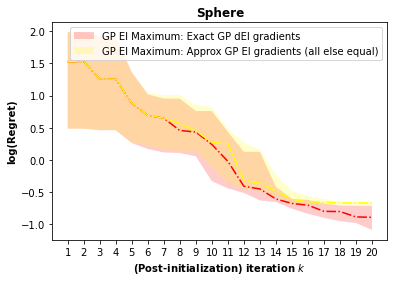

In [142]:
### Visualise!

title = func
plt.figure()

plt.plot(median_ExactSimpleRegret_exact, color = 'Red', ls='-.')
plt.plot(median_ApproxSimpleRegret_exact, color = 'Yellow', ls='-.')

xstar = np.arange(0, iters, step=1)
plt.fill_between(xstar, lower_ExactSimpleRegret_exact, upper_ExactSimpleRegret_exact, facecolor = 'Red', alpha=0.2, label='GP EI Maximum: Exact GP dEI gradients')
plt.fill_between(xstar, lower_ApproxSimpleRegret_exact, upper_ApproxSimpleRegret_exact, facecolor = 'Yellow', alpha=0.2, label='GP EI Maximum: Approx GP EI gradients (all else equal)')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualize!